## Library loading

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, Conv2DTranspose, LeakyReLU, Layer, ZeroPadding2D, Dropout
from tensorflow.keras.activations import tanh
import time
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from scipy.misc import imsave

print(tf.__version__)
tf.enable_eager_execution()


1.13.1


## Hyperparameters

In [ ]:
lr_g = 0.0002
lr_d = 0.0002

## Input image examples

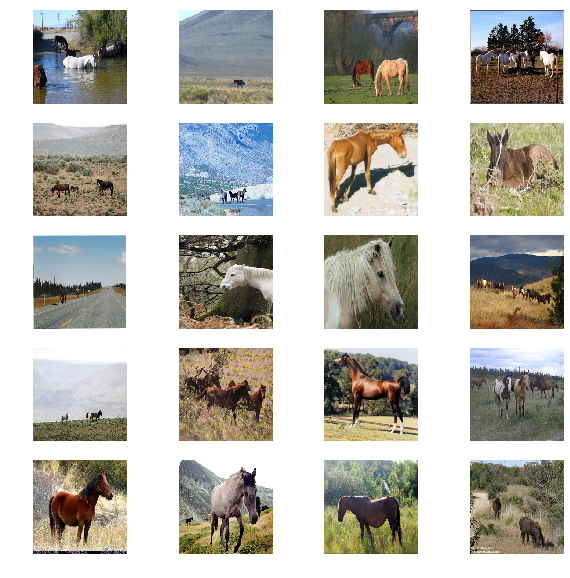

In [54]:
fig = plt.figure(figsize=(10,10))

for i in range(20):
  plt.subplot(5, 4, i+1)
  plt.imshow(((X_train_A[i]+1)*127.5)/255.0)
  plt.axis('off')

## Data loader

In [247]:
def Data_loader(*args):

    for i, folder in enumerate(*args):
        img_list = [img for img in glob.glob(os.path.join(folder, '*'))]
        h, w, c = np.array(Image.open(img_list[0])).shape
        num = len(img_list)
        cnt = 0
        
        if 'trainB' in folder:
            X_train = np.zeros((num - 7, h, w, c)).astype('float32')
        else:
            X_train = np.zeros((num, h, w, c)).astype('float32')
        
        for img_idx in tqdm(range(num)):
            if len(np.array(Image.open(img_list[img_idx])).shape) < 3:
                load_fail_temp = np.array(Image.open(img_list[img_idx])).copy()
            else:
                X_train[cnt] = (np.array(Image.open(img_list[img_idx]))/ 127.5 - 1).astype('float32')  
                cnt += 1            

        if 'trainB' in folder:
            X_train_B = X_train.copy()
        else:
            X_train_A = X_train.copy()
        
    print("{} domain A images loaded ".format(len(X_train_A)))
    print("{} domain B images loaded ".format(len(X_train_B)))

    return X_train_A, X_train_B, load_fail_temp

def _preprocessing(image, resize, crop, crop_size): 
    ''' image flip & domain reshape'''
    image = tf.image.random_flip_left_right(image)        
    image = tf.image.resize_images(image, [resize, resize])
    if crop is True:
        image = tf.random_crop(image, [1, crop_size, crop_size, channels])
    image = tf.cast(image, tf.float32)    
    return image

def dataset_split(X_train, y_train, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size)
    print("Number of train images: {}".format(len(X_train)))
    print("Number of train original domain labels: {}".format(len(y_train)))
    print("Number of test images: {}".format(len(X_test)))
    print("Number of test original domain labels: {}".format(len(y_test)))
    return X_train, X_test, y_train, y_test


def instancenorm2(x):
    
    epsilon = 1e-5
    mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
    scale = tf.get_variable('scale', [x.get_shape()[-1]],
                            initializer=tf.truncated_normal_initializer(
                                mean=1.0, stddev=0.02))
    offset = tf.get_variable(
        'offset', [x.get_shape()[-1]],
        initializer=tf.constant_initializer(0.0))
    out = scale * tf.div(x - mean, tf.sqrt(var + epsilon)) + offset
    
    return out
    
def fake_image_pool(num_fakes, fake, fake_pool):

    if num_fakes < pool_size:
        fake_pool[num_fakes] = fake
        return fake
    else:
        p = np.random.random()
        if p > 0.5:
            random_id = np.random.randint(0, pool_size - 1)
            temp = fake_pool[random_id]
            fake_pool[random_id] = fake
            return temp
        else:
            return fake

def save_images(epoch, i, images_dir, images_tensor):

    if not os.path.exists(images_dir):
        os.makedirs(images_dir)
        
    names = ['inputA_', 'inputB_', 'fakeA_','fakeB_', 'cycleA_', 'cycleB_']
    
    for name, tensor in zip(names, images_tensor):
        image_name = name + str(epoch) + "_" + str(i) + ".jpg"
        imsave(os.path.join(images_dir, image_name), ((np.array(tensor)[0] + 1) * 127.5).astype(np.uint8))     
        

## Model

In [254]:
class Conv2DLayer(tf.keras.layers.Layer):
  def __init__(self, filters=64, size=7, strides=1, padding='VALID', stddev = 0.02, instance_norm=True, relu=True, relufactor=0):
    super(Conv2DLayer, self).__init__()
    self.filters = filters
    self.size = size
    self.strides = strides
    self.padding = padding
    self.stddev = stddev
    self.instance_norm = instance_norm
    self.relu = relu
    self.relufactor = relufactor

  def build(self, input_shape):        
    self.kernel = self.add_weight(name = 'Conv2D',
                                    shape=[self.size, self.size, int(input_shape[-1]), self.filters],
                                    initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=self.stddev),
                                    trainable=True)   
    
    self.bias = self.add_weight(name='Conv2D_bias',
                                shape=(self.filters,),
                                initializer="zeros",
                                trainable=True)
    
  def call(self, input):
    conv = tf.nn.conv2d(input = input, filter = self.kernel, strides = [1,self.strides,self.strides,1], padding=self.padding)
    conv = tf.nn.bias_add(conv, self.bias)    
    if self.instance_norm:
        conv = instancenorm2(conv)
    if self.relu:
        if self.relufactor == 0.0:
            conv = tf.nn.relu(conv)
        else:
            conv = tf.nn.leaky_relu(conv, self.relufactor)
    return conv

    
class Deconv2DLayer(tf.keras.layers.Layer):
  def __init__(self, filters=64, out_shape = None , size=7, strides=1, padding='VALID', stddev = 0.02, instance_norm=True, relu=True, relufactor=0):
    super(Deconv2DLayer, self).__init__()
    self.filters = filters
    self.size = size
    self.strides = strides
    self.padding = padding
    self.stddev = stddev
    self.instance_norm = instance_norm
    self.relu = relu
    self.relufactor = relufactor
    self.out_ = out_shape


  def build(self, input_shape):        
    self.kernel = self.add_weight(name = 'Deconv2D',
                                    shape=[self.size, self.size, self.filters, int(input_shape[-1])],
                                    initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=self.stddev),
                                    trainable=True)   
    
    self.bias = self.add_weight(name= 'Deconv2D_bias',
                                shape=(self.filters,),
                                initializer="zeros",
                                trainable=True)
    
  def call(self, input_tensor):
    conv = tf.nn.conv2d_transpose(value = input_tensor, output_shape = self.out_, filter = self.kernel, strides = [1,self.strides,self.strides,1], padding=self.padding)
    conv = tf.nn.bias_add(conv, self.bias)    
    if self.instance_norm:
        conv = instancenorm2(conv)
    if self.relu:
        if self.relufactor == 0.0:
            conv = tf.nn.relu(conv)
        else:
            conv = tf.nn.leaky_relu(conv, self.relufactor)
    return conv


class ResBlock(tf.keras.Model):
  def __init__(self, filters, padding='REFLECT'):
    super(ResBlock, self).__init__()
    self.conv1 = Conv2DLayer(filters, size=3, strides=1, padding='VALID', stddev = 0.02)
    self.conv2 = Conv2DLayer(filters, size=3, strides=1, padding='VALID', stddev = 0.02, relu=False)
    self.padding = padding
    
  def call(self, x):
    out = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], self.padding)
    out = self.conv1(out)
    out = tf.pad(out, [[0, 0], [1, 1], [1, 1], [0, 0]], self.padding)
    out = self.conv2(out)
    out = tf.nn.relu(x + out)    
    return out


class Build_generator(tf.keras.Model):
  ''' Building a generator'''
  def __init__(self):
    super(Build_generator, self).__init__()
    self.filter_size_a = 7
    self.filter_size_b = 3
    self.initial_filters = 32 
    self.padding = 'REFLECT'
    self.o_c1 = Conv2DLayer(filters=self.initial_filters, size=self.filter_size_a, strides=1,stddev = 0.02)
    self.o_c2 = Conv2DLayer(filters=self.initial_filters*2, size=self.filter_size_b, strides=2, padding = 'SAME', stddev = 0.02)
    self.o_c3 = Conv2DLayer(filters=self.initial_filters*4, size=self.filter_size_b, strides=2, padding = 'SAME', stddev = 0.02)
    self.o_r1 = ResBlock(filters=self.initial_filters*4, padding = self.padding)
    self.o_r2 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r3 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r4 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r5 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r6 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r7 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r8 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_r9 = ResBlock(filters=self.initial_filters*4, padding =self.padding)
    self.o_c4 = Deconv2DLayer(filters=self.initial_filters*2, out_shape =[1, 128, 128, self.initial_filters*2], size=self.filter_size_b, strides=2, padding='SAME', stddev = 0.02)
    self.o_c5 = Deconv2DLayer(filters=self.initial_filters, out_shape = [1, 256, 256, self.initial_filters], size=self.filter_size_b, strides=2, padding='SAME', stddev = 0.02)
    self.o_c6 = Conv2DLayer(filters=3, size=self.filter_size_a, strides=1,stddev = 0.02, padding='SAME', relu=False, instance_norm= False)
    
  def call(self, x, name = 'generator'):
    x_pad = tf.pad(x, [[0, 0], [self.filter_size_b, self.filter_size_b], [self.filter_size_b, self.filter_size_b], [0, 0]], self.padding)
    conv = self.o_c1(x_pad)
    conv = self.o_c2(conv)
    conv = self.o_c3(conv)
    conv = self.o_r1(conv)
    conv = self.o_r2(conv)
    conv = self.o_r3(conv)
    conv = self.o_r4(conv)
    conv = self.o_r5(conv)
    conv = self.o_r6(conv)
    conv = self.o_r7(conv)
    conv = self.o_r8(conv)
    conv = self.o_r9(conv)
    conv = self.o_c4(conv)
    conv = self.o_c5(conv)
    conv = self.o_c6(conv)
    conv = tf.nn.tanh(conv)
    return conv

class Build_discriminator(tf.keras.Model):
  ''' Building a discriminator'''
  def __init__(self):
    super(Build_discriminator, self).__init__()
    self.filter_size = 4
    self.initial_filters = 64
    self.o_c1 = Conv2DLayer(filters=self.initial_filters, size=self.filter_size, strides=2, padding='SAME', stddev = 0.02, instance_norm=False, relufactor=0.2)
    self.o_c2 = Conv2DLayer(filters=self.initial_filters*2, size=self.filter_size, strides=2, padding='SAME', stddev = 0.02, relufactor=0.2)
    self.o_c3 = Conv2DLayer(filters=self.initial_filters*4, size=self.filter_size, strides=2, padding='SAME', stddev = 0.02, relufactor=0.2)
    self.o_c4 = Conv2DLayer(filters=self.initial_filters*8, size=self.filter_size, strides=1, padding='SAME', stddev = 0.02, relufactor=0.2)
    self.o_c5 = Conv2DLayer(filters=1, size=self.filter_size, strides=1, padding='SAME', stddev = 0.02, instance_norm=False, relu=False)

  def __call__(self, input_tensor, name = 'generator'):
    conv = self.o_c1(input_tensor)    
    conv = self.o_c2(conv)    
    conv = self.o_c3(conv)    
    conv = self.o_c4(conv)    
    conv = self.o_c5(conv)    
    return conv 

## Optimizers

In [290]:
gen_optimizer_A = tf.train.AdamOptimizer(learning_rate=lr_g, beta1=0.5)
gen_optimizer_B = tf.train.AdamOptimizer(learning_rate=lr_g, beta1=0.5)
disc_optimizer_A = tf.train.AdamOptimizer(learning_rate=lr_d, beta1=0.5)
disc_optimizer_B = tf.train.AdamOptimizer(learning_rate=lr_d, beta1=0.5)

## Loss functions

In [289]:
def Cycle_consistency_loss(real_images, cycle_images):
    loss = tf.reduce_mean(tf.abs(real_images - cycle_images))
    return loss

def Lsgan_loss_gen(fake_image_probs):
    loss = tf.reduce_mean(tf.squared_difference(fake_image_probs, 1))
    return loss

def Lsgan_loss_disc(real_image_probs, fake_image_probs):
    loss = (tf.reduce_mean(tf.squared_difference(real_image_probs, 1)) + tf.reduce_mean(tf.squared_difference(fake_image_probs, 0))) * 0.5
    return loss

def identity_loss(real_image, fake_image):
    loss = tf.reduce_mean(tf.abs(real_image - fake_image))
    return loss

def compute_gen_loss(input_A, input_B, cycle_A, cycle_B, lam_A, lam_B, fake_prob):    
     loss = lam_A * Cycle_consistency_loss(real_images=input_A, cycle_images=cycle_A) + lam_B * Cycle_consistency_loss(real_images=input_B, cycle_images=cycle_B) + Lsgan_loss_gen(fake_image_probs = fake_prob)     
     return loss

def compute_disc_loss(real_prob, fake_pool_prob):
     loss = Lsgan_loss_disc(real_image_probs=real_prob, fake_image_probs= fake_pool_prob)
     return loss

## Train functions

In [293]:
def train_step(j, train_iterator_A, train_iterator_B, fake_pool_A, fake_pool_B):
    
    global num_fake_inputs, generator_A, generator_B, discriminator_A, discriminator_B
    
    input_image_A = train_iterator_A.get_next()
    input_image_B = train_iterator_B.get_next()
    
    with tf.GradientTape() as gen_tape_A, tf.GradientTape() as gen_tape_B, tf.GradientTape() as disc_tape_A, tf.GradientTape() as disc_tape_B:

        fake_image_A = generator_A(input_image_B, name = 'B_real_2_A_fake')  # B->A
        fake_image_B = generator_B(input_image_A, name = 'A_real_2_B_fake')  # A->B

        cycle_image_A = generator_A(fake_image_B, name = 'B_fake_2_A_cycle')
        cycle_image_B = generator_B(fake_image_A, name = 'A_fake_2_B_cycle')

        fake_prob_A = discriminator_A(fake_image_A, name="fake_prob_A")
        fake_prob_B = discriminator_B(fake_image_B, name="fake_prob_B")

        real_prob_A = discriminator_A(input_image_A, name="real_prob_A")
        real_prob_B = discriminator_B(input_image_B, name="real_prob_B")    

        fake_image_pool_A = fake_image_pool(num_fake_inputs, fake_image_A, fake_pool_A)
        fake_pool_prob_A = discriminator_A(fake_image_pool_A, name="fake_prob_A")
#         fake_pool_prob_A = discriminator_A(fake_image_A, name="fake_prob_A")

        fake_image_pool_B = fake_image_pool(num_fake_inputs, fake_image_B, fake_pool_B)
        fake_pool_prob_B = discriminator_B(fake_image_pool_B, name="fake_prob_B")
#         fake_pool_prob_B = discriminator_B(fake_image_B, name="fake_prob_B")

        gen_loss_A =  compute_gen_loss(input_A = input_image_A, input_B = input_image_B, cycle_A = cycle_image_A, cycle_B = cycle_image_B, lam_A = lambda_A, lam_B = lambda_B, fake_prob = fake_prob_A)
        disc_loss_B = compute_disc_loss(real_prob = real_prob_B, fake_pool_prob = fake_pool_prob_B)
        gen_loss_B =  compute_gen_loss(input_A = input_image_A, input_B = input_image_B, cycle_A = cycle_image_A, cycle_B = cycle_image_B, lam_A = lambda_A, lam_B = lambda_B, fake_prob = fake_prob_B)
        disc_loss_A = compute_disc_loss(real_prob = real_prob_A, fake_pool_prob = fake_pool_prob_A)

    gradients_of_gen_A = gen_tape_A.gradient(gen_loss_A, generator_A.trainable_variables)
    gen_optimizer_A.apply_gradients(zip(gradients_of_gen_A, generator_A.trainable_variables))

    gradients_of_disc_B = disc_tape_B.gradient(disc_loss_B, discriminator_B.trainable_variables)
    disc_optimizer_B.apply_gradients(zip(gradients_of_disc_B, discriminator_B.trainable_variables))

    gradients_of_gen_B = gen_tape_B.gradient(gen_loss_B, generator_B.trainable_variables)    
    gen_optimizer_B.apply_gradients(zip(gradients_of_gen_B, generator_B.trainable_variables))

    gradients_of_disc_A = disc_tape_A.gradient(disc_loss_A, discriminator_A.trainable_variables)
    disc_optimizer_A.apply_gradients(zip(gradients_of_disc_A, discriminator_A.trainable_variables))

    num_fake_inputs += 1 
    
    if j % 100 == 0:
        print('gen_loss_A: ', gen_loss_A)
        print('gen_loss_B: ', gen_loss_B)
        print('disc_loss_A: ', disc_loss_A)
        print('disc_loss_B: ', disc_loss_B)

def train(train_iterator, test_iterator, fake_pool_A, fake_pool_B, epochs, saving_folder, h, w, c, max_images):  

    train_iterator_A, train_iterator_B = train_iterator
    test_iterator_A, test_iterator_B = test_iterator
    
    for epoch in tqdm(range(epochs)):       
        
        i = 0
        while i < 20:
            
            test_image_A = test_iterator_A.get_next()
            test_image_B = test_iterator_B.get_next()
            test_fake_image_A = generator_A(test_image_B)
            test_fake_image_B = generator_B(test_image_A)
            test_cycle_image_A = generator_A(test_fake_image_B)
            test_cycle_image_B = generator_B(test_fake_image_A)

            test_images_tensor = [test_image_A, test_image_B, test_fake_image_A, test_fake_image_B, test_cycle_image_A, test_cycle_image_B]          
            save_images(epoch, i, saving_folder, test_images_tensor)

            i += 1

            
        for j in range(0, max_images):
            print("Epoch {} Processing batch {}/{}".format(epoch+1, j+1, max_images))
            train_step(j, train_iterator_A, train_iterator_B, fake_pool_A, fake_pool_B)  


## Model building

In [294]:
generator_A = Build_generator()
generator_B = Build_generator()
discriminator_A = Build_discriminator()
discriminator_B = Build_discriminator()

## Dataset generation

In [119]:
folder_list = ['/home/Cyclegan_datasets/horse2zebra/trainA/', '/home/Cyclegan_datasets/horse2zebra/trainB/']

X_train_A, X_train_B, load_fails = Data_loader(folder_list)

batch_size = 1
test_batch_size = 1
resize = 286
crop = True
crop_size = 256
channels = 3
buffer = 3000
train_dataset_A = tf.data.Dataset.from_tensor_slices(X_train_A)
train_dataset_A = train_dataset_A.repeat()
train_dataset_A = train_dataset_A.batch(batch_size) 
train_dataset_A = train_dataset_A.shuffle(buffer_size=(int(buffer) * 2 + 3 * batch_size))
train_dataset_A = train_dataset_A.map(lambda x : _preprocessing(x,resize, crop, crop_size))
train_iterator_A = train_dataset_A.make_one_shot_iterator()

train_dataset_B = tf.data.Dataset.from_tensor_slices(X_train_B)
train_dataset_B = train_dataset_B.repeat()
train_dataset_B = train_dataset_B.batch(batch_size) 
train_dataset_B = train_dataset_B.shuffle(buffer_size=(int(buffer) * 2 + 3 * batch_size))
train_dataset_B = train_dataset_B.map(lambda x : _preprocessing(x,resize, crop, crop_size))
train_iterator_B = train_dataset_B.make_one_shot_iterator()

resize = 256
crop = False
crop_size = 256
channels = 3
buffer = 3000

test_dataset_A = tf.data.Dataset.from_tensor_slices((X_train_A))
test_dataset_A = test_dataset_A.repeat()
test_dataset_A = test_dataset_A.batch(batch_size) 
test_dataset_A = test_dataset_A.shuffle(buffer_size=(int(buffer) * 2 + 3 * batch_size))
test_dataset_A = test_dataset_A.map(lambda x: _preprocessing(x, resize, crop, crop_size))
test_iterator_A = test_dataset_A.make_one_shot_iterator()

test_dataset_B = tf.data.Dataset.from_tensor_slices((X_train_B))
test_dataset_B = test_dataset_B.repeat()
test_dataset_B = test_dataset_B.batch(batch_size) 
test_dataset_B = test_dataset_B.shuffle(buffer_size=(int(buffer) * 2 + 3 * batch_size))
test_dataset_B = test_dataset_B.map(lambda x: _preprocessing(x, resize, crop, crop_size))
test_iterator_B = test_dataset_B.make_one_shot_iterator()

train_iterator = (train_iterator_A, train_iterator_B)
test_iterator = (test_iterator_A, test_iterator_B)


100%|██████████| 1334/1334 [00:10<00:00, 134.04it/s]


1067 domain A images loaded 
1327 domain B images loaded 


## Training

In [ ]:
epochs = 200
num_fake_inputs = 0
lambda_A = 10.0
lambda_B = 10.0
lambda_id = 0.5
pool_size = 50

h = 256
w = 256
c = 3
max_images = 1327

fake_pool_A = np.zeros((pool_size, 1, h, w, c), dtype='float32')
fake_pool_B = np.zeros((pool_size, 1, h, w, c), dtype='float32')

saving_folder = '/home/CycleGAN/output/horse2zebra_sep_network_v9_20190620/'
# os.makedirs(saving_folder)

train(train_iterator, test_iterator, fake_pool_A, fake_pool_B, epochs, saving_folder, h, w, c, max_images) 












  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:145: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Epoch 1 Processing batch 1/1327
gen_loss_A:  tf.Tensor(9.515291, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(13.619148, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(1.2381885, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(4.145497, shape=(), dtype=float32)
Epoch 1 Processing batch 2/1327
Epoch 1 Processing batch 3/1327
Epoch 1 Processing batch 4/1327
Epoch 1 Processing batch 5/1327
Epoch 1 Processing batch 6/1327
Epoch 1 Processing batch 7/1327
Epoch 1 Processing batch 8/1327
Epoch 1 Processing batch 9/1327
Epoch 1 Processing batch 10/1327
Epoch 1 Processing batch 11/1327
Epoch 1 Processing batch 12/1327
Epoch 1 Processing batch 13/1327
Epoch 1 Processing batch 14/1327
Epoch 1 Processing batch 15/1327
Epoch 1 Processing batch 16/1327
Epoch 1 Processing batch 17/1327
Epoch 1 Processing batch 18/1327
Epoch 1 Processing batch 19/1327
Epoch 1 Processing batch 20/1327
Epoch 1 Processing batch 21/1327
Epoch 1 Processing batch 22/1327
Epoch 1 Processing batch 23/1327
Epoch 1 Proces












  0%|          | 1/200 [30:28<101:03:22, 1828.16s/it]

Epoch 2 Processing batch 1/1327
gen_loss_A:  tf.Tensor(5.417829, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(6.2546983, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.3164646, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.25230148, shape=(), dtype=float32)
Epoch 2 Processing batch 2/1327
Epoch 2 Processing batch 3/1327
Epoch 2 Processing batch 4/1327
Epoch 2 Processing batch 5/1327
Epoch 2 Processing batch 6/1327
Epoch 2 Processing batch 7/1327
Epoch 2 Processing batch 8/1327
Epoch 2 Processing batch 9/1327
Epoch 2 Processing batch 10/1327
Epoch 2 Processing batch 11/1327
Epoch 2 Processing batch 12/1327
Epoch 2 Processing batch 13/1327
Epoch 2 Processing batch 14/1327
Epoch 2 Processing batch 15/1327
Epoch 2 Processing batch 16/1327
Epoch 2 Processing batch 17/1327
Epoch 2 Processing batch 18/1327
Epoch 2 Processing batch 19/1327
Epoch 2 Processing batch 20/1327
Epoch 2 Processing batch 21/1327
Epoch 2 Processing batch 22/1327
Epoch 2 Processing batch 23/1327
Epoch 2 Proc












  1%|          | 2/200 [1:01:04<100:40:42, 1830.52s/it]

Epoch 3 Processing batch 1/1327
gen_loss_A:  tf.Tensor(5.3571243, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(5.4350233, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.07016529, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09445439, shape=(), dtype=float32)
Epoch 3 Processing batch 2/1327
Epoch 3 Processing batch 3/1327
Epoch 3 Processing batch 4/1327
Epoch 3 Processing batch 5/1327
Epoch 3 Processing batch 6/1327
Epoch 3 Processing batch 7/1327
Epoch 3 Processing batch 8/1327
Epoch 3 Processing batch 9/1327
Epoch 3 Processing batch 10/1327
Epoch 3 Processing batch 11/1327
Epoch 3 Processing batch 12/1327
Epoch 3 Processing batch 13/1327
Epoch 3 Processing batch 14/1327
Epoch 3 Processing batch 15/1327
Epoch 3 Processing batch 16/1327
Epoch 3 Processing batch 17/1327
Epoch 3 Processing batch 18/1327
Epoch 3 Processing batch 19/1327
Epoch 3 Processing batch 20/1327
Epoch 3 Processing batch 21/1327
Epoch 3 Processing batch 22/1327
Epoch 3 Processing batch 23/1327
Epoch 3 Pr












  2%|▏         | 3/200 [1:31:31<100:06:42, 1829.46s/it]

Epoch 4 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.604242, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.643131, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.22091794, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.106270164, shape=(), dtype=float32)
Epoch 4 Processing batch 2/1327
Epoch 4 Processing batch 3/1327
Epoch 4 Processing batch 4/1327
Epoch 4 Processing batch 5/1327
Epoch 4 Processing batch 6/1327
Epoch 4 Processing batch 7/1327
Epoch 4 Processing batch 8/1327
Epoch 4 Processing batch 9/1327
Epoch 4 Processing batch 10/1327
Epoch 4 Processing batch 11/1327
Epoch 4 Processing batch 12/1327
Epoch 4 Processing batch 13/1327
Epoch 4 Processing batch 14/1327
Epoch 4 Processing batch 15/1327
Epoch 4 Processing batch 16/1327
Epoch 4 Processing batch 17/1327
Epoch 4 Processing batch 18/1327
Epoch 4 Processing batch 19/1327
Epoch 4 Processing batch 20/1327
Epoch 4 Processing batch 21/1327
Epoch 4 Processing batch 22/1327
Epoch 4 Processing batch 23/1327
Epoch 4 Pro












  2%|▏         | 4/200 [2:02:06<99:42:23, 1831.34s/it] 

Epoch 5 Processing batch 1/1327
gen_loss_A:  tf.Tensor(6.7027187, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(6.5043883, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.083008505, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.17653197, shape=(), dtype=float32)
Epoch 5 Processing batch 2/1327
Epoch 5 Processing batch 3/1327
Epoch 5 Processing batch 4/1327
Epoch 5 Processing batch 5/1327
Epoch 5 Processing batch 6/1327
Epoch 5 Processing batch 7/1327
Epoch 5 Processing batch 8/1327
Epoch 5 Processing batch 9/1327
Epoch 5 Processing batch 10/1327
Epoch 5 Processing batch 11/1327
Epoch 5 Processing batch 12/1327
Epoch 5 Processing batch 13/1327
Epoch 5 Processing batch 14/1327
Epoch 5 Processing batch 15/1327
Epoch 5 Processing batch 16/1327
Epoch 5 Processing batch 17/1327
Epoch 5 Processing batch 18/1327
Epoch 5 Processing batch 19/1327
Epoch 5 Processing batch 20/1327
Epoch 5 Processing batch 21/1327
Epoch 5 Processing batch 22/1327
Epoch 5 Processing batch 23/1327
Epoch 5 P












  2%|▎         | 5/200 [2:32:37<99:10:42, 1830.99s/it]

Epoch 6 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.6044147, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.30048, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.2364136, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.39595944, shape=(), dtype=float32)
Epoch 6 Processing batch 2/1327
Epoch 6 Processing batch 3/1327
Epoch 6 Processing batch 4/1327
Epoch 6 Processing batch 5/1327
Epoch 6 Processing batch 6/1327
Epoch 6 Processing batch 7/1327
Epoch 6 Processing batch 8/1327
Epoch 6 Processing batch 9/1327
Epoch 6 Processing batch 10/1327
Epoch 6 Processing batch 11/1327
Epoch 6 Processing batch 12/1327
Epoch 6 Processing batch 13/1327
Epoch 6 Processing batch 14/1327
Epoch 6 Processing batch 15/1327
Epoch 6 Processing batch 16/1327
Epoch 6 Processing batch 17/1327
Epoch 6 Processing batch 18/1327
Epoch 6 Processing batch 19/1327
Epoch 6 Processing batch 20/1327
Epoch 6 Processing batch 21/1327
Epoch 6 Processing batch 22/1327
Epoch 6 Processing batch 23/1327
Epoch 6 Proce












  3%|▎         | 6/200 [3:02:55<98:28:05, 1827.24s/it]

Epoch 7 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.858731, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(5.002366, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.2605182, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.11789362, shape=(), dtype=float32)
Epoch 7 Processing batch 2/1327
Epoch 7 Processing batch 3/1327
Epoch 7 Processing batch 4/1327
Epoch 7 Processing batch 5/1327
Epoch 7 Processing batch 6/1327
Epoch 7 Processing batch 7/1327
Epoch 7 Processing batch 8/1327
Epoch 7 Processing batch 9/1327
Epoch 7 Processing batch 10/1327
Epoch 7 Processing batch 11/1327
Epoch 7 Processing batch 12/1327
Epoch 7 Processing batch 13/1327
Epoch 7 Processing batch 14/1327
Epoch 7 Processing batch 15/1327
Epoch 7 Processing batch 16/1327
Epoch 7 Processing batch 17/1327
Epoch 7 Processing batch 18/1327
Epoch 7 Processing batch 19/1327
Epoch 7 Processing batch 20/1327
Epoch 7 Processing batch 21/1327
Epoch 7 Processing batch 22/1327
Epoch 7 Processing batch 23/1327
Epoch 7 Proce












  4%|▎         | 7/200 [3:33:23<97:58:44, 1827.59s/it]

Epoch 8 Processing batch 1/1327
gen_loss_A:  tf.Tensor(5.2451673, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(5.303521, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15626317, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.1191068, shape=(), dtype=float32)
Epoch 8 Processing batch 2/1327
Epoch 8 Processing batch 3/1327
Epoch 8 Processing batch 4/1327
Epoch 8 Processing batch 5/1327
Epoch 8 Processing batch 6/1327
Epoch 8 Processing batch 7/1327
Epoch 8 Processing batch 8/1327
Epoch 8 Processing batch 9/1327
Epoch 8 Processing batch 10/1327
Epoch 8 Processing batch 11/1327
Epoch 8 Processing batch 12/1327
Epoch 8 Processing batch 13/1327
Epoch 8 Processing batch 14/1327
Epoch 8 Processing batch 15/1327
Epoch 8 Processing batch 16/1327
Epoch 8 Processing batch 17/1327
Epoch 8 Processing batch 18/1327
Epoch 8 Processing batch 19/1327
Epoch 8 Processing batch 20/1327
Epoch 8 Processing batch 21/1327
Epoch 8 Processing batch 22/1327
Epoch 8 Processing batch 23/1327
Epoch 8 Proc












  4%|▍         | 8/200 [4:03:52<97:28:52, 1827.77s/it]

Epoch 9 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9337943, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.9841595, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.29837704, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.29475582, shape=(), dtype=float32)
Epoch 9 Processing batch 2/1327
Epoch 9 Processing batch 3/1327
Epoch 9 Processing batch 4/1327
Epoch 9 Processing batch 5/1327
Epoch 9 Processing batch 6/1327
Epoch 9 Processing batch 7/1327
Epoch 9 Processing batch 8/1327
Epoch 9 Processing batch 9/1327
Epoch 9 Processing batch 10/1327
Epoch 9 Processing batch 11/1327
Epoch 9 Processing batch 12/1327
Epoch 9 Processing batch 13/1327
Epoch 9 Processing batch 14/1327
Epoch 9 Processing batch 15/1327
Epoch 9 Processing batch 16/1327
Epoch 9 Processing batch 17/1327
Epoch 9 Processing batch 18/1327
Epoch 9 Processing batch 19/1327
Epoch 9 Processing batch 20/1327
Epoch 9 Processing batch 21/1327
Epoch 9 Processing batch 22/1327
Epoch 9 Processing batch 23/1327
Epoch 9 Pr












  4%|▍         | 9/200 [4:34:56<97:33:00, 1838.64s/it]

Epoch 10 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.9338465, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.2347565, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.5184023, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.515179, shape=(), dtype=float32)
Epoch 10 Processing batch 2/1327
Epoch 10 Processing batch 3/1327
Epoch 10 Processing batch 4/1327
Epoch 10 Processing batch 5/1327
Epoch 10 Processing batch 6/1327
Epoch 10 Processing batch 7/1327
Epoch 10 Processing batch 8/1327
Epoch 10 Processing batch 9/1327
Epoch 10 Processing batch 10/1327
Epoch 10 Processing batch 11/1327
Epoch 10 Processing batch 12/1327
Epoch 10 Processing batch 13/1327
Epoch 10 Processing batch 14/1327
Epoch 10 Processing batch 15/1327
Epoch 10 Processing batch 16/1327
Epoch 10 Processing batch 17/1327
Epoch 10 Processing batch 18/1327
Epoch 10 Processing batch 19/1327
Epoch 10 Processing batch 20/1327
Epoch 10 Processing batch 21/1327
Epoch 10 Processing batch 22/1327
Epoch 10 Processing batc












  5%|▌         | 10/200 [5:06:22<97:48:02, 1853.07s/it]

Epoch 11 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.03638, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.2455907, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.2978854, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.110090084, shape=(), dtype=float32)
Epoch 11 Processing batch 2/1327
Epoch 11 Processing batch 3/1327
Epoch 11 Processing batch 4/1327
Epoch 11 Processing batch 5/1327
Epoch 11 Processing batch 6/1327
Epoch 11 Processing batch 7/1327
Epoch 11 Processing batch 8/1327
Epoch 11 Processing batch 9/1327
Epoch 11 Processing batch 10/1327
Epoch 11 Processing batch 11/1327
Epoch 11 Processing batch 12/1327
Epoch 11 Processing batch 13/1327
Epoch 11 Processing batch 14/1327
Epoch 11 Processing batch 15/1327
Epoch 11 Processing batch 16/1327
Epoch 11 Processing batch 17/1327
Epoch 11 Processing batch 18/1327
Epoch 11 Processing batch 19/1327
Epoch 11 Processing batch 20/1327
Epoch 11 Processing batch 21/1327
Epoch 11 Processing batch 22/1327
Epoch 11 Processing bat












  6%|▌         | 11/200 [5:37:02<97:04:32, 1849.06s/it]

Epoch 12 Processing batch 1/1327
gen_loss_A:  tf.Tensor(5.152664, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(5.384673, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.23635186, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06884216, shape=(), dtype=float32)
Epoch 12 Processing batch 2/1327
Epoch 12 Processing batch 3/1327
Epoch 12 Processing batch 4/1327
Epoch 12 Processing batch 5/1327
Epoch 12 Processing batch 6/1327
Epoch 12 Processing batch 7/1327
Epoch 12 Processing batch 8/1327
Epoch 12 Processing batch 9/1327
Epoch 12 Processing batch 10/1327
Epoch 12 Processing batch 11/1327
Epoch 12 Processing batch 12/1327
Epoch 12 Processing batch 13/1327
Epoch 12 Processing batch 14/1327
Epoch 12 Processing batch 15/1327
Epoch 12 Processing batch 16/1327
Epoch 12 Processing batch 17/1327
Epoch 12 Processing batch 18/1327
Epoch 12 Processing batch 19/1327
Epoch 12 Processing batch 20/1327
Epoch 12 Processing batch 21/1327
Epoch 12 Processing batch 22/1327
Epoch 12 Processing bat












  6%|▌         | 12/200 [6:07:43<96:25:46, 1846.52s/it]

Epoch 13 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.6126797, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.9804754, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.40100038, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.25867733, shape=(), dtype=float32)
Epoch 13 Processing batch 2/1327
Epoch 13 Processing batch 3/1327
Epoch 13 Processing batch 4/1327
Epoch 13 Processing batch 5/1327
Epoch 13 Processing batch 6/1327
Epoch 13 Processing batch 7/1327
Epoch 13 Processing batch 8/1327
Epoch 13 Processing batch 9/1327
Epoch 13 Processing batch 10/1327
Epoch 13 Processing batch 11/1327
Epoch 13 Processing batch 12/1327
Epoch 13 Processing batch 13/1327
Epoch 13 Processing batch 14/1327
Epoch 13 Processing batch 15/1327
Epoch 13 Processing batch 16/1327
Epoch 13 Processing batch 17/1327
Epoch 13 Processing batch 18/1327
Epoch 13 Processing batch 19/1327
Epoch 13 Processing batch 20/1327
Epoch 13 Processing batch 21/1327
Epoch 13 Processing batch 22/1327
Epoch 13 Processing b












  6%|▋         | 13/200 [6:38:27<95:53:21, 1846.00s/it]

Epoch 14 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9206426, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.151263, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.29526022, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.33676395, shape=(), dtype=float32)
Epoch 14 Processing batch 2/1327
Epoch 14 Processing batch 3/1327
Epoch 14 Processing batch 4/1327
Epoch 14 Processing batch 5/1327
Epoch 14 Processing batch 6/1327
Epoch 14 Processing batch 7/1327
Epoch 14 Processing batch 8/1327
Epoch 14 Processing batch 9/1327
Epoch 14 Processing batch 10/1327
Epoch 14 Processing batch 11/1327
Epoch 14 Processing batch 12/1327
Epoch 14 Processing batch 13/1327
Epoch 14 Processing batch 14/1327
Epoch 14 Processing batch 15/1327
Epoch 14 Processing batch 16/1327
Epoch 14 Processing batch 17/1327
Epoch 14 Processing batch 18/1327
Epoch 14 Processing batch 19/1327
Epoch 14 Processing batch 20/1327
Epoch 14 Processing batch 21/1327
Epoch 14 Processing batch 22/1327
Epoch 14 Processing ba












  7%|▋         | 14/200 [7:08:57<95:07:08, 1841.01s/it]

Epoch 15 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.0148335, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.54358, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12543854, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10751296, shape=(), dtype=float32)
Epoch 15 Processing batch 2/1327
Epoch 15 Processing batch 3/1327
Epoch 15 Processing batch 4/1327
Epoch 15 Processing batch 5/1327
Epoch 15 Processing batch 6/1327
Epoch 15 Processing batch 7/1327
Epoch 15 Processing batch 8/1327
Epoch 15 Processing batch 9/1327
Epoch 15 Processing batch 10/1327
Epoch 15 Processing batch 11/1327
Epoch 15 Processing batch 12/1327
Epoch 15 Processing batch 13/1327
Epoch 15 Processing batch 14/1327
Epoch 15 Processing batch 15/1327
Epoch 15 Processing batch 16/1327
Epoch 15 Processing batch 17/1327
Epoch 15 Processing batch 18/1327
Epoch 15 Processing batch 19/1327
Epoch 15 Processing batch 20/1327
Epoch 15 Processing batch 21/1327
Epoch 15 Processing batch 22/1327
Epoch 15 Processing bat












  8%|▊         | 15/200 [7:39:30<94:29:20, 1838.71s/it]

Epoch 16 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8729818, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.292762, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12720759, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08402635, shape=(), dtype=float32)
Epoch 16 Processing batch 2/1327
Epoch 16 Processing batch 3/1327
Epoch 16 Processing batch 4/1327
Epoch 16 Processing batch 5/1327
Epoch 16 Processing batch 6/1327
Epoch 16 Processing batch 7/1327
Epoch 16 Processing batch 8/1327
Epoch 16 Processing batch 9/1327
Epoch 16 Processing batch 10/1327
Epoch 16 Processing batch 11/1327
Epoch 16 Processing batch 12/1327
Epoch 16 Processing batch 13/1327
Epoch 16 Processing batch 14/1327
Epoch 16 Processing batch 15/1327
Epoch 16 Processing batch 16/1327
Epoch 16 Processing batch 17/1327
Epoch 16 Processing batch 18/1327
Epoch 16 Processing batch 19/1327
Epoch 16 Processing batch 20/1327
Epoch 16 Processing batch 21/1327
Epoch 16 Processing batch 22/1327
Epoch 16 Processing ba












  8%|▊         | 16/200 [8:09:55<93:45:42, 1834.47s/it]

Epoch 17 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.7857177, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.5014772, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.23183149, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.1572052, shape=(), dtype=float32)
Epoch 17 Processing batch 2/1327
Epoch 17 Processing batch 3/1327
Epoch 17 Processing batch 4/1327
Epoch 17 Processing batch 5/1327
Epoch 17 Processing batch 6/1327
Epoch 17 Processing batch 7/1327
Epoch 17 Processing batch 8/1327
Epoch 17 Processing batch 9/1327
Epoch 17 Processing batch 10/1327
Epoch 17 Processing batch 11/1327
Epoch 17 Processing batch 12/1327
Epoch 17 Processing batch 13/1327
Epoch 17 Processing batch 14/1327
Epoch 17 Processing batch 15/1327
Epoch 17 Processing batch 16/1327
Epoch 17 Processing batch 17/1327
Epoch 17 Processing batch 18/1327
Epoch 17 Processing batch 19/1327
Epoch 17 Processing batch 20/1327
Epoch 17 Processing batch 21/1327
Epoch 17 Processing batch 22/1327
Epoch 17 Processing ba












  8%|▊         | 17/200 [8:40:21<93:07:22, 1831.93s/it]

Epoch 18 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.2387383, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.8558726, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.16591245, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08295399, shape=(), dtype=float32)
Epoch 18 Processing batch 2/1327
Epoch 18 Processing batch 3/1327
Epoch 18 Processing batch 4/1327
Epoch 18 Processing batch 5/1327
Epoch 18 Processing batch 6/1327
Epoch 18 Processing batch 7/1327
Epoch 18 Processing batch 8/1327
Epoch 18 Processing batch 9/1327
Epoch 18 Processing batch 10/1327
Epoch 18 Processing batch 11/1327
Epoch 18 Processing batch 12/1327
Epoch 18 Processing batch 13/1327
Epoch 18 Processing batch 14/1327
Epoch 18 Processing batch 15/1327
Epoch 18 Processing batch 16/1327
Epoch 18 Processing batch 17/1327
Epoch 18 Processing batch 18/1327
Epoch 18 Processing batch 19/1327
Epoch 18 Processing batch 20/1327
Epoch 18 Processing batch 21/1327
Epoch 18 Processing batch 22/1327
Epoch 18 Processing b












  9%|▉         | 18/200 [9:10:45<92:29:46, 1829.60s/it]

Epoch 19 Processing batch 1/1327
gen_loss_A:  tf.Tensor(5.8087687, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(6.2706175, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11420793, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.106591105, shape=(), dtype=float32)
Epoch 19 Processing batch 2/1327
Epoch 19 Processing batch 3/1327
Epoch 19 Processing batch 4/1327
Epoch 19 Processing batch 5/1327
Epoch 19 Processing batch 6/1327
Epoch 19 Processing batch 7/1327
Epoch 19 Processing batch 8/1327
Epoch 19 Processing batch 9/1327
Epoch 19 Processing batch 10/1327
Epoch 19 Processing batch 11/1327
Epoch 19 Processing batch 12/1327
Epoch 19 Processing batch 13/1327
Epoch 19 Processing batch 14/1327
Epoch 19 Processing batch 15/1327
Epoch 19 Processing batch 16/1327
Epoch 19 Processing batch 17/1327
Epoch 19 Processing batch 18/1327
Epoch 19 Processing batch 19/1327
Epoch 19 Processing batch 20/1327
Epoch 19 Processing batch 21/1327
Epoch 19 Processing batch 22/1327
Epoch 19 Processing 












 10%|▉         | 19/200 [9:41:19<92:03:25, 1830.97s/it]

Epoch 20 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.5400887, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2010462, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12494035, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.11892028, shape=(), dtype=float32)
Epoch 20 Processing batch 2/1327
Epoch 20 Processing batch 3/1327
Epoch 20 Processing batch 4/1327
Epoch 20 Processing batch 5/1327
Epoch 20 Processing batch 6/1327
Epoch 20 Processing batch 7/1327
Epoch 20 Processing batch 8/1327
Epoch 20 Processing batch 9/1327
Epoch 20 Processing batch 10/1327
Epoch 20 Processing batch 11/1327
Epoch 20 Processing batch 12/1327
Epoch 20 Processing batch 13/1327
Epoch 20 Processing batch 14/1327
Epoch 20 Processing batch 15/1327
Epoch 20 Processing batch 16/1327
Epoch 20 Processing batch 17/1327
Epoch 20 Processing batch 18/1327
Epoch 20 Processing batch 19/1327
Epoch 20 Processing batch 20/1327
Epoch 20 Processing batch 21/1327
Epoch 20 Processing batch 22/1327
Epoch 20 Processing b












 10%|█         | 20/200 [10:11:52<91:34:37, 1831.54s/it]

Epoch 21 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.7386484, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0015383, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.3595177, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.3194957, shape=(), dtype=float32)
Epoch 21 Processing batch 2/1327
Epoch 21 Processing batch 3/1327
Epoch 21 Processing batch 4/1327
Epoch 21 Processing batch 5/1327
Epoch 21 Processing batch 6/1327
Epoch 21 Processing batch 7/1327
Epoch 21 Processing batch 8/1327
Epoch 21 Processing batch 9/1327
Epoch 21 Processing batch 10/1327
Epoch 21 Processing batch 11/1327
Epoch 21 Processing batch 12/1327
Epoch 21 Processing batch 13/1327
Epoch 21 Processing batch 14/1327
Epoch 21 Processing batch 15/1327
Epoch 21 Processing batch 16/1327
Epoch 21 Processing batch 17/1327
Epoch 21 Processing batch 18/1327
Epoch 21 Processing batch 19/1327
Epoch 21 Processing batch 20/1327
Epoch 21 Processing batch 21/1327
Epoch 21 Processing batch 22/1327
Epoch 21 Processing bat












 10%|█         | 21/200 [10:42:20<91:00:43, 1830.41s/it]

Epoch 22 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9183073, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.534884, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.6791477, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.43258274, shape=(), dtype=float32)
Epoch 22 Processing batch 2/1327
Epoch 22 Processing batch 3/1327
Epoch 22 Processing batch 4/1327
Epoch 22 Processing batch 5/1327
Epoch 22 Processing batch 6/1327
Epoch 22 Processing batch 7/1327
Epoch 22 Processing batch 8/1327
Epoch 22 Processing batch 9/1327
Epoch 22 Processing batch 10/1327
Epoch 22 Processing batch 11/1327
Epoch 22 Processing batch 12/1327
Epoch 22 Processing batch 13/1327
Epoch 22 Processing batch 14/1327
Epoch 22 Processing batch 15/1327
Epoch 22 Processing batch 16/1327
Epoch 22 Processing batch 17/1327
Epoch 22 Processing batch 18/1327
Epoch 22 Processing batch 19/1327
Epoch 22 Processing batch 20/1327
Epoch 22 Processing batch 21/1327
Epoch 22 Processing batch 22/1327
Epoch 22 Processing bat












 11%|█         | 22/200 [11:12:54<90:33:38, 1831.56s/it]

Epoch 23 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.690945, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.8283627, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.25344974, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.29531074, shape=(), dtype=float32)
Epoch 23 Processing batch 2/1327
Epoch 23 Processing batch 3/1327
Epoch 23 Processing batch 4/1327
Epoch 23 Processing batch 5/1327
Epoch 23 Processing batch 6/1327
Epoch 23 Processing batch 7/1327
Epoch 23 Processing batch 8/1327
Epoch 23 Processing batch 9/1327
Epoch 23 Processing batch 10/1327
Epoch 23 Processing batch 11/1327
Epoch 23 Processing batch 12/1327
Epoch 23 Processing batch 13/1327
Epoch 23 Processing batch 14/1327
Epoch 23 Processing batch 15/1327
Epoch 23 Processing batch 16/1327
Epoch 23 Processing batch 17/1327
Epoch 23 Processing batch 18/1327
Epoch 23 Processing batch 19/1327
Epoch 23 Processing batch 20/1327
Epoch 23 Processing batch 21/1327
Epoch 23 Processing batch 22/1327
Epoch 23 Processing ba












 12%|█▏        | 23/200 [11:43:26<90:03:33, 1831.72s/it]

Epoch 24 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3528042, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.7246845, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.25119662, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07887433, shape=(), dtype=float32)
Epoch 24 Processing batch 2/1327
Epoch 24 Processing batch 3/1327
Epoch 24 Processing batch 4/1327
Epoch 24 Processing batch 5/1327
Epoch 24 Processing batch 6/1327
Epoch 24 Processing batch 7/1327
Epoch 24 Processing batch 8/1327
Epoch 24 Processing batch 9/1327
Epoch 24 Processing batch 10/1327
Epoch 24 Processing batch 11/1327
Epoch 24 Processing batch 12/1327
Epoch 24 Processing batch 13/1327
Epoch 24 Processing batch 14/1327
Epoch 24 Processing batch 15/1327
Epoch 24 Processing batch 16/1327
Epoch 24 Processing batch 17/1327
Epoch 24 Processing batch 18/1327
Epoch 24 Processing batch 19/1327
Epoch 24 Processing batch 20/1327
Epoch 24 Processing batch 21/1327
Epoch 24 Processing batch 22/1327
Epoch 24 Processing b












 12%|█▏        | 24/200 [12:13:58<89:33:19, 1831.81s/it]

Epoch 25 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.31041, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.32639, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.16629712, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.13172606, shape=(), dtype=float32)
Epoch 25 Processing batch 2/1327
Epoch 25 Processing batch 3/1327
Epoch 25 Processing batch 4/1327
Epoch 25 Processing batch 5/1327
Epoch 25 Processing batch 6/1327
Epoch 25 Processing batch 7/1327
Epoch 25 Processing batch 8/1327
Epoch 25 Processing batch 9/1327
Epoch 25 Processing batch 10/1327
Epoch 25 Processing batch 11/1327
Epoch 25 Processing batch 12/1327
Epoch 25 Processing batch 13/1327
Epoch 25 Processing batch 14/1327
Epoch 25 Processing batch 15/1327
Epoch 25 Processing batch 16/1327
Epoch 25 Processing batch 17/1327
Epoch 25 Processing batch 18/1327
Epoch 25 Processing batch 19/1327
Epoch 25 Processing batch 20/1327
Epoch 25 Processing batch 21/1327
Epoch 25 Processing batch 22/1327
Epoch 25 Processing batch












 12%|█▎        | 25/200 [12:44:34<89:06:27, 1833.07s/it]

Epoch 26 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.6976838, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.208169, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13991727, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.1648266, shape=(), dtype=float32)
Epoch 26 Processing batch 2/1327
Epoch 26 Processing batch 3/1327
Epoch 26 Processing batch 4/1327
Epoch 26 Processing batch 5/1327
Epoch 26 Processing batch 6/1327
Epoch 26 Processing batch 7/1327
Epoch 26 Processing batch 8/1327
Epoch 26 Processing batch 9/1327
Epoch 26 Processing batch 10/1327
Epoch 26 Processing batch 11/1327
Epoch 26 Processing batch 12/1327
Epoch 26 Processing batch 13/1327
Epoch 26 Processing batch 14/1327
Epoch 26 Processing batch 15/1327
Epoch 26 Processing batch 16/1327
Epoch 26 Processing batch 17/1327
Epoch 26 Processing batch 18/1327
Epoch 26 Processing batch 19/1327
Epoch 26 Processing batch 20/1327
Epoch 26 Processing batch 21/1327
Epoch 26 Processing batch 22/1327
Epoch 26 Processing bat












 13%|█▎        | 26/200 [13:15:09<88:37:46, 1833.72s/it]

Epoch 27 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8704844, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.8845944, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.2167287, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.21040228, shape=(), dtype=float32)
Epoch 27 Processing batch 2/1327
Epoch 27 Processing batch 3/1327
Epoch 27 Processing batch 4/1327
Epoch 27 Processing batch 5/1327
Epoch 27 Processing batch 6/1327
Epoch 27 Processing batch 7/1327
Epoch 27 Processing batch 8/1327
Epoch 27 Processing batch 9/1327
Epoch 27 Processing batch 10/1327
Epoch 27 Processing batch 11/1327
Epoch 27 Processing batch 12/1327
Epoch 27 Processing batch 13/1327
Epoch 27 Processing batch 14/1327
Epoch 27 Processing batch 15/1327
Epoch 27 Processing batch 16/1327
Epoch 27 Processing batch 17/1327
Epoch 27 Processing batch 18/1327
Epoch 27 Processing batch 19/1327
Epoch 27 Processing batch 20/1327
Epoch 27 Processing batch 21/1327
Epoch 27 Processing batch 22/1327
Epoch 27 Processing ba












 14%|█▎        | 27/200 [13:45:32<87:57:22, 1830.30s/it]

Epoch 28 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.4478395, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.4751515, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1540322, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.13628227, shape=(), dtype=float32)
Epoch 28 Processing batch 2/1327
Epoch 28 Processing batch 3/1327
Epoch 28 Processing batch 4/1327
Epoch 28 Processing batch 5/1327
Epoch 28 Processing batch 6/1327
Epoch 28 Processing batch 7/1327
Epoch 28 Processing batch 8/1327
Epoch 28 Processing batch 9/1327
Epoch 28 Processing batch 10/1327
Epoch 28 Processing batch 11/1327
Epoch 28 Processing batch 12/1327
Epoch 28 Processing batch 13/1327
Epoch 28 Processing batch 14/1327
Epoch 28 Processing batch 15/1327
Epoch 28 Processing batch 16/1327
Epoch 28 Processing batch 17/1327
Epoch 28 Processing batch 18/1327
Epoch 28 Processing batch 19/1327
Epoch 28 Processing batch 20/1327
Epoch 28 Processing batch 21/1327
Epoch 28 Processing batch 22/1327
Epoch 28 Processing ba












 14%|█▍        | 28/200 [14:15:52<87:18:15, 1827.30s/it]

Epoch 29 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.2913928, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2654438, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09210895, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.037876923, shape=(), dtype=float32)
Epoch 29 Processing batch 2/1327
Epoch 29 Processing batch 3/1327
Epoch 29 Processing batch 4/1327
Epoch 29 Processing batch 5/1327
Epoch 29 Processing batch 6/1327
Epoch 29 Processing batch 7/1327
Epoch 29 Processing batch 8/1327
Epoch 29 Processing batch 9/1327
Epoch 29 Processing batch 10/1327
Epoch 29 Processing batch 11/1327
Epoch 29 Processing batch 12/1327
Epoch 29 Processing batch 13/1327
Epoch 29 Processing batch 14/1327
Epoch 29 Processing batch 15/1327
Epoch 29 Processing batch 16/1327
Epoch 29 Processing batch 17/1327
Epoch 29 Processing batch 18/1327
Epoch 29 Processing batch 19/1327
Epoch 29 Processing batch 20/1327
Epoch 29 Processing batch 21/1327
Epoch 29 Processing batch 22/1327
Epoch 29 Processing 












 14%|█▍        | 29/200 [14:46:10<86:39:43, 1824.47s/it]

Epoch 30 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.1010458, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.6023655, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11912256, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.020105008, shape=(), dtype=float32)
Epoch 30 Processing batch 2/1327
Epoch 30 Processing batch 3/1327
Epoch 30 Processing batch 4/1327
Epoch 30 Processing batch 5/1327
Epoch 30 Processing batch 6/1327
Epoch 30 Processing batch 7/1327
Epoch 30 Processing batch 8/1327
Epoch 30 Processing batch 9/1327
Epoch 30 Processing batch 10/1327
Epoch 30 Processing batch 11/1327
Epoch 30 Processing batch 12/1327
Epoch 30 Processing batch 13/1327
Epoch 30 Processing batch 14/1327
Epoch 30 Processing batch 15/1327
Epoch 30 Processing batch 16/1327
Epoch 30 Processing batch 17/1327
Epoch 30 Processing batch 18/1327
Epoch 30 Processing batch 19/1327
Epoch 30 Processing batch 20/1327
Epoch 30 Processing batch 21/1327
Epoch 30 Processing batch 22/1327
Epoch 30 Processing 












 15%|█▌        | 30/200 [15:16:25<86:01:39, 1821.76s/it]

Epoch 31 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.1044571, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.5665193, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15099174, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.14172775, shape=(), dtype=float32)
Epoch 31 Processing batch 2/1327
Epoch 31 Processing batch 3/1327
Epoch 31 Processing batch 4/1327
Epoch 31 Processing batch 5/1327
Epoch 31 Processing batch 6/1327
Epoch 31 Processing batch 7/1327
Epoch 31 Processing batch 8/1327
Epoch 31 Processing batch 9/1327
Epoch 31 Processing batch 10/1327
Epoch 31 Processing batch 11/1327
Epoch 31 Processing batch 12/1327
Epoch 31 Processing batch 13/1327
Epoch 31 Processing batch 14/1327
Epoch 31 Processing batch 15/1327
Epoch 31 Processing batch 16/1327
Epoch 31 Processing batch 17/1327
Epoch 31 Processing batch 18/1327
Epoch 31 Processing batch 19/1327
Epoch 31 Processing batch 20/1327
Epoch 31 Processing batch 21/1327
Epoch 31 Processing batch 22/1327
Epoch 31 Processing b












 16%|█▌        | 31/200 [15:46:59<85:41:46, 1825.48s/it]

Epoch 32 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3215184, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1321778, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09607923, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09155737, shape=(), dtype=float32)
Epoch 32 Processing batch 2/1327
Epoch 32 Processing batch 3/1327
Epoch 32 Processing batch 4/1327
Epoch 32 Processing batch 5/1327
Epoch 32 Processing batch 6/1327
Epoch 32 Processing batch 7/1327
Epoch 32 Processing batch 8/1327
Epoch 32 Processing batch 9/1327
Epoch 32 Processing batch 10/1327
Epoch 32 Processing batch 11/1327
Epoch 32 Processing batch 12/1327
Epoch 32 Processing batch 13/1327
Epoch 32 Processing batch 14/1327
Epoch 32 Processing batch 15/1327
Epoch 32 Processing batch 16/1327
Epoch 32 Processing batch 17/1327
Epoch 32 Processing batch 18/1327
Epoch 32 Processing batch 19/1327
Epoch 32 Processing batch 20/1327
Epoch 32 Processing batch 21/1327
Epoch 32 Processing batch 22/1327
Epoch 32 Processing b












 16%|█▌        | 32/200 [16:17:19<85:06:32, 1823.77s/it]

Epoch 33 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.933254, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.01371, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.27167687, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.16438171, shape=(), dtype=float32)
Epoch 33 Processing batch 2/1327
Epoch 33 Processing batch 3/1327
Epoch 33 Processing batch 4/1327
Epoch 33 Processing batch 5/1327
Epoch 33 Processing batch 6/1327
Epoch 33 Processing batch 7/1327
Epoch 33 Processing batch 8/1327
Epoch 33 Processing batch 9/1327
Epoch 33 Processing batch 10/1327
Epoch 33 Processing batch 11/1327
Epoch 33 Processing batch 12/1327
Epoch 33 Processing batch 13/1327
Epoch 33 Processing batch 14/1327
Epoch 33 Processing batch 15/1327
Epoch 33 Processing batch 16/1327
Epoch 33 Processing batch 17/1327
Epoch 33 Processing batch 18/1327
Epoch 33 Processing batch 19/1327
Epoch 33 Processing batch 20/1327
Epoch 33 Processing batch 21/1327
Epoch 33 Processing batch 22/1327
Epoch 33 Processing batc












 16%|█▋        | 33/200 [16:47:36<84:30:11, 1821.62s/it]

Epoch 34 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.8089652, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0229902, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.100869715, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.03225999, shape=(), dtype=float32)
Epoch 34 Processing batch 2/1327
Epoch 34 Processing batch 3/1327
Epoch 34 Processing batch 4/1327
Epoch 34 Processing batch 5/1327
Epoch 34 Processing batch 6/1327
Epoch 34 Processing batch 7/1327
Epoch 34 Processing batch 8/1327
Epoch 34 Processing batch 9/1327
Epoch 34 Processing batch 10/1327
Epoch 34 Processing batch 11/1327
Epoch 34 Processing batch 12/1327
Epoch 34 Processing batch 13/1327
Epoch 34 Processing batch 14/1327
Epoch 34 Processing batch 15/1327
Epoch 34 Processing batch 16/1327
Epoch 34 Processing batch 17/1327
Epoch 34 Processing batch 18/1327
Epoch 34 Processing batch 19/1327
Epoch 34 Processing batch 20/1327
Epoch 34 Processing batch 21/1327
Epoch 34 Processing batch 22/1327
Epoch 34 Processing 












 17%|█▋        | 34/200 [17:18:09<84:09:46, 1825.22s/it]

Epoch 35 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.8916302, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0537033, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14435154, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08335319, shape=(), dtype=float32)
Epoch 35 Processing batch 2/1327
Epoch 35 Processing batch 3/1327
Epoch 35 Processing batch 4/1327
Epoch 35 Processing batch 5/1327
Epoch 35 Processing batch 6/1327
Epoch 35 Processing batch 7/1327
Epoch 35 Processing batch 8/1327
Epoch 35 Processing batch 9/1327
Epoch 35 Processing batch 10/1327
Epoch 35 Processing batch 11/1327
Epoch 35 Processing batch 12/1327
Epoch 35 Processing batch 13/1327
Epoch 35 Processing batch 14/1327
Epoch 35 Processing batch 15/1327
Epoch 35 Processing batch 16/1327
Epoch 35 Processing batch 17/1327
Epoch 35 Processing batch 18/1327
Epoch 35 Processing batch 19/1327
Epoch 35 Processing batch 20/1327
Epoch 35 Processing batch 21/1327
Epoch 35 Processing batch 22/1327
Epoch 35 Processing b












 18%|█▊        | 35/200 [17:48:31<83:35:58, 1823.99s/it]

Epoch 36 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0820162, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3119798, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.25027707, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.19456106, shape=(), dtype=float32)
Epoch 36 Processing batch 2/1327
Epoch 36 Processing batch 3/1327
Epoch 36 Processing batch 4/1327
Epoch 36 Processing batch 5/1327
Epoch 36 Processing batch 6/1327
Epoch 36 Processing batch 7/1327
Epoch 36 Processing batch 8/1327
Epoch 36 Processing batch 9/1327
Epoch 36 Processing batch 10/1327
Epoch 36 Processing batch 11/1327
Epoch 36 Processing batch 12/1327
Epoch 36 Processing batch 13/1327
Epoch 36 Processing batch 14/1327
Epoch 36 Processing batch 15/1327
Epoch 36 Processing batch 16/1327
Epoch 36 Processing batch 17/1327
Epoch 36 Processing batch 18/1327
Epoch 36 Processing batch 19/1327
Epoch 36 Processing batch 20/1327
Epoch 36 Processing batch 21/1327
Epoch 36 Processing batch 22/1327
Epoch 36 Processing b












 18%|█▊        | 36/200 [18:18:40<82:54:01, 1819.76s/it]

Epoch 37 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9418259, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.9905455, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.06433846, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.04788243, shape=(), dtype=float32)
Epoch 37 Processing batch 2/1327
Epoch 37 Processing batch 3/1327
Epoch 37 Processing batch 4/1327
Epoch 37 Processing batch 5/1327
Epoch 37 Processing batch 6/1327
Epoch 37 Processing batch 7/1327
Epoch 37 Processing batch 8/1327
Epoch 37 Processing batch 9/1327
Epoch 37 Processing batch 10/1327
Epoch 37 Processing batch 11/1327
Epoch 37 Processing batch 12/1327
Epoch 37 Processing batch 13/1327
Epoch 37 Processing batch 14/1327
Epoch 37 Processing batch 15/1327
Epoch 37 Processing batch 16/1327
Epoch 37 Processing batch 17/1327
Epoch 37 Processing batch 18/1327
Epoch 37 Processing batch 19/1327
Epoch 37 Processing batch 20/1327
Epoch 37 Processing batch 21/1327
Epoch 37 Processing batch 22/1327
Epoch 37 Processing b












 18%|█▊        | 37/200 [18:49:02<82:25:11, 1820.32s/it]

Epoch 38 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0619009, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.344869, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12903771, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.110337466, shape=(), dtype=float32)
Epoch 38 Processing batch 2/1327
Epoch 38 Processing batch 3/1327
Epoch 38 Processing batch 4/1327
Epoch 38 Processing batch 5/1327
Epoch 38 Processing batch 6/1327
Epoch 38 Processing batch 7/1327
Epoch 38 Processing batch 8/1327
Epoch 38 Processing batch 9/1327
Epoch 38 Processing batch 10/1327
Epoch 38 Processing batch 11/1327
Epoch 38 Processing batch 12/1327
Epoch 38 Processing batch 13/1327
Epoch 38 Processing batch 14/1327
Epoch 38 Processing batch 15/1327
Epoch 38 Processing batch 16/1327
Epoch 38 Processing batch 17/1327
Epoch 38 Processing batch 18/1327
Epoch 38 Processing batch 19/1327
Epoch 38 Processing batch 20/1327
Epoch 38 Processing batch 21/1327
Epoch 38 Processing batch 22/1327
Epoch 38 Processing b












 19%|█▉        | 38/200 [19:19:14<81:47:42, 1817.67s/it]

Epoch 39 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.4187822, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.8303773, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.095300905, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.0323798, shape=(), dtype=float32)
Epoch 39 Processing batch 2/1327
Epoch 39 Processing batch 3/1327
Epoch 39 Processing batch 4/1327
Epoch 39 Processing batch 5/1327
Epoch 39 Processing batch 6/1327
Epoch 39 Processing batch 7/1327
Epoch 39 Processing batch 8/1327
Epoch 39 Processing batch 9/1327
Epoch 39 Processing batch 10/1327
Epoch 39 Processing batch 11/1327
Epoch 39 Processing batch 12/1327
Epoch 39 Processing batch 13/1327
Epoch 39 Processing batch 14/1327
Epoch 39 Processing batch 15/1327
Epoch 39 Processing batch 16/1327
Epoch 39 Processing batch 17/1327
Epoch 39 Processing batch 18/1327
Epoch 39 Processing batch 19/1327
Epoch 39 Processing batch 20/1327
Epoch 39 Processing batch 21/1327
Epoch 39 Processing batch 22/1327
Epoch 39 Processing b












 20%|█▉        | 39/200 [19:49:21<81:09:16, 1814.64s/it]

Epoch 40 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3570225, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0476518, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.10992822, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.1531797, shape=(), dtype=float32)
Epoch 40 Processing batch 2/1327
Epoch 40 Processing batch 3/1327
Epoch 40 Processing batch 4/1327
Epoch 40 Processing batch 5/1327
Epoch 40 Processing batch 6/1327
Epoch 40 Processing batch 7/1327
Epoch 40 Processing batch 8/1327
Epoch 40 Processing batch 9/1327
Epoch 40 Processing batch 10/1327
Epoch 40 Processing batch 11/1327
Epoch 40 Processing batch 12/1327
Epoch 40 Processing batch 13/1327
Epoch 40 Processing batch 14/1327
Epoch 40 Processing batch 15/1327
Epoch 40 Processing batch 16/1327
Epoch 40 Processing batch 17/1327
Epoch 40 Processing batch 18/1327
Epoch 40 Processing batch 19/1327
Epoch 40 Processing batch 20/1327
Epoch 40 Processing batch 21/1327
Epoch 40 Processing batch 22/1327
Epoch 40 Processing ba












 20%|██        | 40/200 [20:19:34<80:37:26, 1814.04s/it]

Epoch 41 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.4272857, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.377751, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09419161, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.02757407, shape=(), dtype=float32)
Epoch 41 Processing batch 2/1327
Epoch 41 Processing batch 3/1327
Epoch 41 Processing batch 4/1327
Epoch 41 Processing batch 5/1327
Epoch 41 Processing batch 6/1327
Epoch 41 Processing batch 7/1327
Epoch 41 Processing batch 8/1327
Epoch 41 Processing batch 9/1327
Epoch 41 Processing batch 10/1327
Epoch 41 Processing batch 11/1327
Epoch 41 Processing batch 12/1327
Epoch 41 Processing batch 13/1327
Epoch 41 Processing batch 14/1327
Epoch 41 Processing batch 15/1327
Epoch 41 Processing batch 16/1327
Epoch 41 Processing batch 17/1327
Epoch 41 Processing batch 18/1327
Epoch 41 Processing batch 19/1327
Epoch 41 Processing batch 20/1327
Epoch 41 Processing batch 21/1327
Epoch 41 Processing batch 22/1327
Epoch 41 Processing ba












 20%|██        | 41/200 [20:49:52<80:10:24, 1815.25s/it]

Epoch 42 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.2279506, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.3901706, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.08824834, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.087211415, shape=(), dtype=float32)
Epoch 42 Processing batch 2/1327
Epoch 42 Processing batch 3/1327
Epoch 42 Processing batch 4/1327
Epoch 42 Processing batch 5/1327
Epoch 42 Processing batch 6/1327
Epoch 42 Processing batch 7/1327
Epoch 42 Processing batch 8/1327
Epoch 42 Processing batch 9/1327
Epoch 42 Processing batch 10/1327
Epoch 42 Processing batch 11/1327
Epoch 42 Processing batch 12/1327
Epoch 42 Processing batch 13/1327
Epoch 42 Processing batch 14/1327
Epoch 42 Processing batch 15/1327
Epoch 42 Processing batch 16/1327
Epoch 42 Processing batch 17/1327
Epoch 42 Processing batch 18/1327
Epoch 42 Processing batch 19/1327
Epoch 42 Processing batch 20/1327
Epoch 42 Processing batch 21/1327
Epoch 42 Processing batch 22/1327
Epoch 42 Processing 












 21%|██        | 42/200 [21:20:14<79:45:52, 1817.42s/it]

Epoch 43 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.815702, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.212815, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14456007, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.044845976, shape=(), dtype=float32)
Epoch 43 Processing batch 2/1327
Epoch 43 Processing batch 3/1327
Epoch 43 Processing batch 4/1327
Epoch 43 Processing batch 5/1327
Epoch 43 Processing batch 6/1327
Epoch 43 Processing batch 7/1327
Epoch 43 Processing batch 8/1327
Epoch 43 Processing batch 9/1327
Epoch 43 Processing batch 10/1327
Epoch 43 Processing batch 11/1327
Epoch 43 Processing batch 12/1327
Epoch 43 Processing batch 13/1327
Epoch 43 Processing batch 14/1327
Epoch 43 Processing batch 15/1327
Epoch 43 Processing batch 16/1327
Epoch 43 Processing batch 17/1327
Epoch 43 Processing batch 18/1327
Epoch 43 Processing batch 19/1327
Epoch 43 Processing batch 20/1327
Epoch 43 Processing batch 21/1327
Epoch 43 Processing batch 22/1327
Epoch 43 Processing ba












 22%|██▏       | 43/200 [21:50:34<79:17:37, 1818.20s/it]

Epoch 44 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.8935113, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.048109, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.08135775, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.0508574, shape=(), dtype=float32)
Epoch 44 Processing batch 2/1327
Epoch 44 Processing batch 3/1327
Epoch 44 Processing batch 4/1327
Epoch 44 Processing batch 5/1327
Epoch 44 Processing batch 6/1327
Epoch 44 Processing batch 7/1327
Epoch 44 Processing batch 8/1327
Epoch 44 Processing batch 9/1327
Epoch 44 Processing batch 10/1327
Epoch 44 Processing batch 11/1327
Epoch 44 Processing batch 12/1327
Epoch 44 Processing batch 13/1327
Epoch 44 Processing batch 14/1327
Epoch 44 Processing batch 15/1327
Epoch 44 Processing batch 16/1327
Epoch 44 Processing batch 17/1327
Epoch 44 Processing batch 18/1327
Epoch 44 Processing batch 19/1327
Epoch 44 Processing batch 20/1327
Epoch 44 Processing batch 21/1327
Epoch 44 Processing batch 22/1327
Epoch 44 Processing bat












 22%|██▏       | 44/200 [22:20:43<78:40:14, 1815.48s/it]

Epoch 45 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8437703, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.2983923, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.042346783, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.034242462, shape=(), dtype=float32)
Epoch 45 Processing batch 2/1327
Epoch 45 Processing batch 3/1327
Epoch 45 Processing batch 4/1327
Epoch 45 Processing batch 5/1327
Epoch 45 Processing batch 6/1327
Epoch 45 Processing batch 7/1327
Epoch 45 Processing batch 8/1327
Epoch 45 Processing batch 9/1327
Epoch 45 Processing batch 10/1327
Epoch 45 Processing batch 11/1327
Epoch 45 Processing batch 12/1327
Epoch 45 Processing batch 13/1327
Epoch 45 Processing batch 14/1327
Epoch 45 Processing batch 15/1327
Epoch 45 Processing batch 16/1327
Epoch 45 Processing batch 17/1327
Epoch 45 Processing batch 18/1327
Epoch 45 Processing batch 19/1327
Epoch 45 Processing batch 20/1327
Epoch 45 Processing batch 21/1327
Epoch 45 Processing batch 22/1327
Epoch 45 Processing












 22%|██▎       | 45/200 [22:51:08<78:16:36, 1818.04s/it]

Epoch 46 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.466323, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1128097, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.24934709, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.019620497, shape=(), dtype=float32)
Epoch 46 Processing batch 2/1327
Epoch 46 Processing batch 3/1327
Epoch 46 Processing batch 4/1327
Epoch 46 Processing batch 5/1327
Epoch 46 Processing batch 6/1327
Epoch 46 Processing batch 7/1327
Epoch 46 Processing batch 8/1327
Epoch 46 Processing batch 9/1327
Epoch 46 Processing batch 10/1327
Epoch 46 Processing batch 11/1327
Epoch 46 Processing batch 12/1327
Epoch 46 Processing batch 13/1327
Epoch 46 Processing batch 14/1327
Epoch 46 Processing batch 15/1327
Epoch 46 Processing batch 16/1327
Epoch 46 Processing batch 17/1327
Epoch 46 Processing batch 18/1327
Epoch 46 Processing batch 19/1327
Epoch 46 Processing batch 20/1327
Epoch 46 Processing batch 21/1327
Epoch 46 Processing batch 22/1327
Epoch 46 Processing b












 23%|██▎       | 46/200 [23:21:29<77:49:06, 1819.14s/it]

Epoch 47 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3993583, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.9033241, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.025067206, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08082886, shape=(), dtype=float32)
Epoch 47 Processing batch 2/1327
Epoch 47 Processing batch 3/1327
Epoch 47 Processing batch 4/1327
Epoch 47 Processing batch 5/1327
Epoch 47 Processing batch 6/1327
Epoch 47 Processing batch 7/1327
Epoch 47 Processing batch 8/1327
Epoch 47 Processing batch 9/1327
Epoch 47 Processing batch 10/1327
Epoch 47 Processing batch 11/1327
Epoch 47 Processing batch 12/1327
Epoch 47 Processing batch 13/1327
Epoch 47 Processing batch 14/1327
Epoch 47 Processing batch 15/1327
Epoch 47 Processing batch 16/1327
Epoch 47 Processing batch 17/1327
Epoch 47 Processing batch 18/1327
Epoch 47 Processing batch 19/1327
Epoch 47 Processing batch 20/1327
Epoch 47 Processing batch 21/1327
Epoch 47 Processing batch 22/1327
Epoch 47 Processing 












 24%|██▎       | 47/200 [23:51:52<77:21:26, 1820.17s/it]

Epoch 48 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0652618, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1109114, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09128973, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.038837425, shape=(), dtype=float32)
Epoch 48 Processing batch 2/1327
Epoch 48 Processing batch 3/1327
Epoch 48 Processing batch 4/1327
Epoch 48 Processing batch 5/1327
Epoch 48 Processing batch 6/1327
Epoch 48 Processing batch 7/1327
Epoch 48 Processing batch 8/1327
Epoch 48 Processing batch 9/1327
Epoch 48 Processing batch 10/1327
Epoch 48 Processing batch 11/1327
Epoch 48 Processing batch 12/1327
Epoch 48 Processing batch 13/1327
Epoch 48 Processing batch 14/1327
Epoch 48 Processing batch 15/1327
Epoch 48 Processing batch 16/1327
Epoch 48 Processing batch 17/1327
Epoch 48 Processing batch 18/1327
Epoch 48 Processing batch 19/1327
Epoch 48 Processing batch 20/1327
Epoch 48 Processing batch 21/1327
Epoch 48 Processing batch 22/1327
Epoch 48 Processing 












 24%|██▍       | 48/200 [24:22:20<76:57:34, 1822.73s/it]

Epoch 49 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.1837764, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.495924, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.10806605, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06844738, shape=(), dtype=float32)
Epoch 49 Processing batch 2/1327
Epoch 49 Processing batch 3/1327
Epoch 49 Processing batch 4/1327
Epoch 49 Processing batch 5/1327
Epoch 49 Processing batch 6/1327
Epoch 49 Processing batch 7/1327
Epoch 49 Processing batch 8/1327
Epoch 49 Processing batch 9/1327
Epoch 49 Processing batch 10/1327
Epoch 49 Processing batch 11/1327
Epoch 49 Processing batch 12/1327
Epoch 49 Processing batch 13/1327
Epoch 49 Processing batch 14/1327
Epoch 49 Processing batch 15/1327
Epoch 49 Processing batch 16/1327
Epoch 49 Processing batch 17/1327
Epoch 49 Processing batch 18/1327
Epoch 49 Processing batch 19/1327
Epoch 49 Processing batch 20/1327
Epoch 49 Processing batch 21/1327
Epoch 49 Processing batch 22/1327
Epoch 49 Processing ba












 24%|██▍       | 49/200 [24:52:43<76:26:43, 1822.54s/it]

Epoch 50 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.2102895, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2384672, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.07209556, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.04111457, shape=(), dtype=float32)
Epoch 50 Processing batch 2/1327
Epoch 50 Processing batch 3/1327
Epoch 50 Processing batch 4/1327
Epoch 50 Processing batch 5/1327
Epoch 50 Processing batch 6/1327
Epoch 50 Processing batch 7/1327
Epoch 50 Processing batch 8/1327
Epoch 50 Processing batch 9/1327
Epoch 50 Processing batch 10/1327
Epoch 50 Processing batch 11/1327
Epoch 50 Processing batch 12/1327
Epoch 50 Processing batch 13/1327
Epoch 50 Processing batch 14/1327
Epoch 50 Processing batch 15/1327
Epoch 50 Processing batch 16/1327
Epoch 50 Processing batch 17/1327
Epoch 50 Processing batch 18/1327
Epoch 50 Processing batch 19/1327
Epoch 50 Processing batch 20/1327
Epoch 50 Processing batch 21/1327
Epoch 50 Processing batch 22/1327
Epoch 50 Processing b












 25%|██▌       | 50/200 [25:23:02<75:54:14, 1821.70s/it]

Epoch 51 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.7804198, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.5556161, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.02596394, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.026239268, shape=(), dtype=float32)
Epoch 51 Processing batch 2/1327
Epoch 51 Processing batch 3/1327
Epoch 51 Processing batch 4/1327
Epoch 51 Processing batch 5/1327
Epoch 51 Processing batch 6/1327
Epoch 51 Processing batch 7/1327
Epoch 51 Processing batch 8/1327
Epoch 51 Processing batch 9/1327
Epoch 51 Processing batch 10/1327
Epoch 51 Processing batch 11/1327
Epoch 51 Processing batch 12/1327
Epoch 51 Processing batch 13/1327
Epoch 51 Processing batch 14/1327
Epoch 51 Processing batch 15/1327
Epoch 51 Processing batch 16/1327
Epoch 51 Processing batch 17/1327
Epoch 51 Processing batch 18/1327
Epoch 51 Processing batch 19/1327
Epoch 51 Processing batch 20/1327
Epoch 51 Processing batch 21/1327
Epoch 51 Processing batch 22/1327
Epoch 51 Processing 












 26%|██▌       | 51/200 [25:53:29<75:27:29, 1823.15s/it]

Epoch 52 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.914978, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1959345, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.07934179, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10901344, shape=(), dtype=float32)
Epoch 52 Processing batch 2/1327
Epoch 52 Processing batch 3/1327
Epoch 52 Processing batch 4/1327
Epoch 52 Processing batch 5/1327
Epoch 52 Processing batch 6/1327
Epoch 52 Processing batch 7/1327
Epoch 52 Processing batch 8/1327
Epoch 52 Processing batch 9/1327
Epoch 52 Processing batch 10/1327
Epoch 52 Processing batch 11/1327
Epoch 52 Processing batch 12/1327
Epoch 52 Processing batch 13/1327
Epoch 52 Processing batch 14/1327
Epoch 52 Processing batch 15/1327
Epoch 52 Processing batch 16/1327
Epoch 52 Processing batch 17/1327
Epoch 52 Processing batch 18/1327
Epoch 52 Processing batch 19/1327
Epoch 52 Processing batch 20/1327
Epoch 52 Processing batch 21/1327
Epoch 52 Processing batch 22/1327
Epoch 52 Processing ba












 26%|██▌       | 52/200 [26:24:02<75:04:47, 1826.27s/it]

Epoch 53 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.971459, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3211572, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09238121, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.12914386, shape=(), dtype=float32)
Epoch 53 Processing batch 2/1327
Epoch 53 Processing batch 3/1327
Epoch 53 Processing batch 4/1327
Epoch 53 Processing batch 5/1327
Epoch 53 Processing batch 6/1327
Epoch 53 Processing batch 7/1327
Epoch 53 Processing batch 8/1327
Epoch 53 Processing batch 9/1327
Epoch 53 Processing batch 10/1327
Epoch 53 Processing batch 11/1327
Epoch 53 Processing batch 12/1327
Epoch 53 Processing batch 13/1327
Epoch 53 Processing batch 14/1327
Epoch 53 Processing batch 15/1327
Epoch 53 Processing batch 16/1327
Epoch 53 Processing batch 17/1327
Epoch 53 Processing batch 18/1327
Epoch 53 Processing batch 19/1327
Epoch 53 Processing batch 20/1327
Epoch 53 Processing batch 21/1327
Epoch 53 Processing batch 22/1327
Epoch 53 Processing ba












 26%|██▋       | 53/200 [26:54:46<74:47:16, 1831.54s/it]

Epoch 54 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.670177, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.6748633, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1302309, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09605348, shape=(), dtype=float32)
Epoch 54 Processing batch 2/1327
Epoch 54 Processing batch 3/1327
Epoch 54 Processing batch 4/1327
Epoch 54 Processing batch 5/1327
Epoch 54 Processing batch 6/1327
Epoch 54 Processing batch 7/1327
Epoch 54 Processing batch 8/1327
Epoch 54 Processing batch 9/1327
Epoch 54 Processing batch 10/1327
Epoch 54 Processing batch 11/1327
Epoch 54 Processing batch 12/1327
Epoch 54 Processing batch 13/1327
Epoch 54 Processing batch 14/1327
Epoch 54 Processing batch 15/1327
Epoch 54 Processing batch 16/1327
Epoch 54 Processing batch 17/1327
Epoch 54 Processing batch 18/1327
Epoch 54 Processing batch 19/1327
Epoch 54 Processing batch 20/1327
Epoch 54 Processing batch 21/1327
Epoch 54 Processing batch 22/1327
Epoch 54 Processing bat












 27%|██▋       | 54/200 [27:25:14<74:13:50, 1830.35s/it]

Epoch 55 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.6160316, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.9437156, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.048895445, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.029303765, shape=(), dtype=float32)
Epoch 55 Processing batch 2/1327
Epoch 55 Processing batch 3/1327
Epoch 55 Processing batch 4/1327
Epoch 55 Processing batch 5/1327
Epoch 55 Processing batch 6/1327
Epoch 55 Processing batch 7/1327
Epoch 55 Processing batch 8/1327
Epoch 55 Processing batch 9/1327
Epoch 55 Processing batch 10/1327
Epoch 55 Processing batch 11/1327
Epoch 55 Processing batch 12/1327
Epoch 55 Processing batch 13/1327
Epoch 55 Processing batch 14/1327
Epoch 55 Processing batch 15/1327
Epoch 55 Processing batch 16/1327
Epoch 55 Processing batch 17/1327
Epoch 55 Processing batch 18/1327
Epoch 55 Processing batch 19/1327
Epoch 55 Processing batch 20/1327
Epoch 55 Processing batch 21/1327
Epoch 55 Processing batch 22/1327
Epoch 55 Processing












 28%|██▊       | 55/200 [27:55:34<73:35:40, 1827.18s/it]

Epoch 56 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9889858, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2987003, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12954767, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.1295582, shape=(), dtype=float32)
Epoch 56 Processing batch 2/1327
Epoch 56 Processing batch 3/1327
Epoch 56 Processing batch 4/1327
Epoch 56 Processing batch 5/1327
Epoch 56 Processing batch 6/1327
Epoch 56 Processing batch 7/1327
Epoch 56 Processing batch 8/1327
Epoch 56 Processing batch 9/1327
Epoch 56 Processing batch 10/1327
Epoch 56 Processing batch 11/1327
Epoch 56 Processing batch 12/1327
Epoch 56 Processing batch 13/1327
Epoch 56 Processing batch 14/1327
Epoch 56 Processing batch 15/1327
Epoch 56 Processing batch 16/1327
Epoch 56 Processing batch 17/1327
Epoch 56 Processing batch 18/1327
Epoch 56 Processing batch 19/1327
Epoch 56 Processing batch 20/1327
Epoch 56 Processing batch 21/1327
Epoch 56 Processing batch 22/1327
Epoch 56 Processing ba












 28%|██▊       | 56/200 [28:26:04<73:07:26, 1828.10s/it]

Epoch 57 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3746967, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.656724, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12177746, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.017972078, shape=(), dtype=float32)
Epoch 57 Processing batch 2/1327
Epoch 57 Processing batch 3/1327
Epoch 57 Processing batch 4/1327
Epoch 57 Processing batch 5/1327
Epoch 57 Processing batch 6/1327
Epoch 57 Processing batch 7/1327
Epoch 57 Processing batch 8/1327
Epoch 57 Processing batch 9/1327
Epoch 57 Processing batch 10/1327
Epoch 57 Processing batch 11/1327
Epoch 57 Processing batch 12/1327
Epoch 57 Processing batch 13/1327
Epoch 57 Processing batch 14/1327
Epoch 57 Processing batch 15/1327
Epoch 57 Processing batch 16/1327
Epoch 57 Processing batch 17/1327
Epoch 57 Processing batch 18/1327
Epoch 57 Processing batch 19/1327
Epoch 57 Processing batch 20/1327
Epoch 57 Processing batch 21/1327
Epoch 57 Processing batch 22/1327
Epoch 57 Processing b












 28%|██▊       | 57/200 [28:56:32<72:37:21, 1828.26s/it]

Epoch 58 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0458124, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.7572083, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.21636185, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07594558, shape=(), dtype=float32)
Epoch 58 Processing batch 2/1327
Epoch 58 Processing batch 3/1327
Epoch 58 Processing batch 4/1327
Epoch 58 Processing batch 5/1327
Epoch 58 Processing batch 6/1327
Epoch 58 Processing batch 7/1327
Epoch 58 Processing batch 8/1327
Epoch 58 Processing batch 9/1327
Epoch 58 Processing batch 10/1327
Epoch 58 Processing batch 11/1327
Epoch 58 Processing batch 12/1327
Epoch 58 Processing batch 13/1327
Epoch 58 Processing batch 14/1327
Epoch 58 Processing batch 15/1327
Epoch 58 Processing batch 16/1327
Epoch 58 Processing batch 17/1327
Epoch 58 Processing batch 18/1327
Epoch 58 Processing batch 19/1327
Epoch 58 Processing batch 20/1327
Epoch 58 Processing batch 21/1327
Epoch 58 Processing batch 22/1327
Epoch 58 Processing b












 29%|██▉       | 58/200 [29:26:47<71:57:23, 1824.25s/it]

Epoch 59 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5128946, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.4453382, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14110401, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.05896245, shape=(), dtype=float32)
Epoch 59 Processing batch 2/1327
Epoch 59 Processing batch 3/1327
Epoch 59 Processing batch 4/1327
Epoch 59 Processing batch 5/1327
Epoch 59 Processing batch 6/1327
Epoch 59 Processing batch 7/1327
Epoch 59 Processing batch 8/1327
Epoch 59 Processing batch 9/1327
Epoch 59 Processing batch 10/1327
Epoch 59 Processing batch 11/1327
Epoch 59 Processing batch 12/1327
Epoch 59 Processing batch 13/1327
Epoch 59 Processing batch 14/1327
Epoch 59 Processing batch 15/1327
Epoch 59 Processing batch 16/1327
Epoch 59 Processing batch 17/1327
Epoch 59 Processing batch 18/1327
Epoch 59 Processing batch 19/1327
Epoch 59 Processing batch 20/1327
Epoch 59 Processing batch 21/1327
Epoch 59 Processing batch 22/1327
Epoch 59 Processing b












 30%|██▉       | 59/200 [29:57:15<71:29:23, 1825.27s/it]

Epoch 60 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.3879104, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.436317, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.26125175, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.24680784, shape=(), dtype=float32)
Epoch 60 Processing batch 2/1327
Epoch 60 Processing batch 3/1327
Epoch 60 Processing batch 4/1327
Epoch 60 Processing batch 5/1327
Epoch 60 Processing batch 6/1327
Epoch 60 Processing batch 7/1327
Epoch 60 Processing batch 8/1327
Epoch 60 Processing batch 9/1327
Epoch 60 Processing batch 10/1327
Epoch 60 Processing batch 11/1327
Epoch 60 Processing batch 12/1327
Epoch 60 Processing batch 13/1327
Epoch 60 Processing batch 14/1327
Epoch 60 Processing batch 15/1327
Epoch 60 Processing batch 16/1327
Epoch 60 Processing batch 17/1327
Epoch 60 Processing batch 18/1327
Epoch 60 Processing batch 19/1327
Epoch 60 Processing batch 20/1327
Epoch 60 Processing batch 21/1327
Epoch 60 Processing batch 22/1327
Epoch 60 Processing ba












 30%|███       | 60/200 [30:27:47<71:03:28, 1827.20s/it]

Epoch 61 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5594907, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0474958, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13413493, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.15870899, shape=(), dtype=float32)
Epoch 61 Processing batch 2/1327
Epoch 61 Processing batch 3/1327
Epoch 61 Processing batch 4/1327
Epoch 61 Processing batch 5/1327
Epoch 61 Processing batch 6/1327
Epoch 61 Processing batch 7/1327
Epoch 61 Processing batch 8/1327
Epoch 61 Processing batch 9/1327
Epoch 61 Processing batch 10/1327
Epoch 61 Processing batch 11/1327
Epoch 61 Processing batch 12/1327
Epoch 61 Processing batch 13/1327
Epoch 61 Processing batch 14/1327
Epoch 61 Processing batch 15/1327
Epoch 61 Processing batch 16/1327
Epoch 61 Processing batch 17/1327
Epoch 61 Processing batch 18/1327
Epoch 61 Processing batch 19/1327
Epoch 61 Processing batch 20/1327
Epoch 61 Processing batch 21/1327
Epoch 61 Processing batch 22/1327
Epoch 61 Processing b












 30%|███       | 61/200 [30:58:16<70:34:40, 1827.92s/it]

Epoch 62 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.61292, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.8513536, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.06575065, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07595512, shape=(), dtype=float32)
Epoch 62 Processing batch 2/1327
Epoch 62 Processing batch 3/1327
Epoch 62 Processing batch 4/1327
Epoch 62 Processing batch 5/1327
Epoch 62 Processing batch 6/1327
Epoch 62 Processing batch 7/1327
Epoch 62 Processing batch 8/1327
Epoch 62 Processing batch 9/1327
Epoch 62 Processing batch 10/1327
Epoch 62 Processing batch 11/1327
Epoch 62 Processing batch 12/1327
Epoch 62 Processing batch 13/1327
Epoch 62 Processing batch 14/1327
Epoch 62 Processing batch 15/1327
Epoch 62 Processing batch 16/1327
Epoch 62 Processing batch 17/1327
Epoch 62 Processing batch 18/1327
Epoch 62 Processing batch 19/1327
Epoch 62 Processing batch 20/1327
Epoch 62 Processing batch 21/1327
Epoch 62 Processing batch 22/1327
Epoch 62 Processing bat












 31%|███       | 62/200 [31:28:48<70:07:00, 1829.13s/it]

Epoch 63 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.9734375, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.1901207, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.06589141, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.043178283, shape=(), dtype=float32)
Epoch 63 Processing batch 2/1327
Epoch 63 Processing batch 3/1327
Epoch 63 Processing batch 4/1327
Epoch 63 Processing batch 5/1327
Epoch 63 Processing batch 6/1327
Epoch 63 Processing batch 7/1327
Epoch 63 Processing batch 8/1327
Epoch 63 Processing batch 9/1327
Epoch 63 Processing batch 10/1327
Epoch 63 Processing batch 11/1327
Epoch 63 Processing batch 12/1327
Epoch 63 Processing batch 13/1327
Epoch 63 Processing batch 14/1327
Epoch 63 Processing batch 15/1327
Epoch 63 Processing batch 16/1327
Epoch 63 Processing batch 17/1327
Epoch 63 Processing batch 18/1327
Epoch 63 Processing batch 19/1327
Epoch 63 Processing batch 20/1327
Epoch 63 Processing batch 21/1327
Epoch 63 Processing batch 22/1327
Epoch 63 Processing 












 32%|███▏      | 63/200 [31:59:13<69:33:44, 1827.92s/it]

Epoch 64 Processing batch 1/1327
gen_loss_A:  tf.Tensor(1.8179266, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.0836985, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.2645892, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.102596045, shape=(), dtype=float32)
Epoch 64 Processing batch 2/1327
Epoch 64 Processing batch 3/1327
Epoch 64 Processing batch 4/1327
Epoch 64 Processing batch 5/1327
Epoch 64 Processing batch 6/1327
Epoch 64 Processing batch 7/1327
Epoch 64 Processing batch 8/1327
Epoch 64 Processing batch 9/1327
Epoch 64 Processing batch 10/1327
Epoch 64 Processing batch 11/1327
Epoch 64 Processing batch 12/1327
Epoch 64 Processing batch 13/1327
Epoch 64 Processing batch 14/1327
Epoch 64 Processing batch 15/1327
Epoch 64 Processing batch 16/1327
Epoch 64 Processing batch 17/1327
Epoch 64 Processing batch 18/1327
Epoch 64 Processing batch 19/1327
Epoch 64 Processing batch 20/1327
Epoch 64 Processing batch 21/1327
Epoch 64 Processing batch 22/1327
Epoch 64 Processing b












 32%|███▏      | 64/200 [32:29:39<69:02:00, 1827.36s/it]

Epoch 65 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.4412096, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.492376, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11881444, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.074467376, shape=(), dtype=float32)
Epoch 65 Processing batch 2/1327
Epoch 65 Processing batch 3/1327
Epoch 65 Processing batch 4/1327
Epoch 65 Processing batch 5/1327
Epoch 65 Processing batch 6/1327
Epoch 65 Processing batch 7/1327
Epoch 65 Processing batch 8/1327
Epoch 65 Processing batch 9/1327
Epoch 65 Processing batch 10/1327
Epoch 65 Processing batch 11/1327
Epoch 65 Processing batch 12/1327
Epoch 65 Processing batch 13/1327
Epoch 65 Processing batch 14/1327
Epoch 65 Processing batch 15/1327
Epoch 65 Processing batch 16/1327
Epoch 65 Processing batch 17/1327
Epoch 65 Processing batch 18/1327
Epoch 65 Processing batch 19/1327
Epoch 65 Processing batch 20/1327
Epoch 65 Processing batch 21/1327
Epoch 65 Processing batch 22/1327
Epoch 65 Processing b












 32%|███▎      | 65/200 [33:00:03<68:29:11, 1826.31s/it]

Epoch 66 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.7306387, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3855882, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.05061865, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.070803225, shape=(), dtype=float32)
Epoch 66 Processing batch 2/1327
Epoch 66 Processing batch 3/1327
Epoch 66 Processing batch 4/1327
Epoch 66 Processing batch 5/1327
Epoch 66 Processing batch 6/1327
Epoch 66 Processing batch 7/1327
Epoch 66 Processing batch 8/1327
Epoch 66 Processing batch 9/1327
Epoch 66 Processing batch 10/1327
Epoch 66 Processing batch 11/1327
Epoch 66 Processing batch 12/1327
Epoch 66 Processing batch 13/1327
Epoch 66 Processing batch 14/1327
Epoch 66 Processing batch 15/1327
Epoch 66 Processing batch 16/1327
Epoch 66 Processing batch 17/1327
Epoch 66 Processing batch 18/1327
Epoch 66 Processing batch 19/1327
Epoch 66 Processing batch 20/1327
Epoch 66 Processing batch 21/1327
Epoch 66 Processing batch 22/1327
Epoch 66 Processing 












 33%|███▎      | 66/200 [33:30:39<68:04:43, 1828.98s/it]

Epoch 67 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.2720385, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3383303, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.20742494, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.113268696, shape=(), dtype=float32)
Epoch 67 Processing batch 2/1327
Epoch 67 Processing batch 3/1327
Epoch 67 Processing batch 4/1327
Epoch 67 Processing batch 5/1327
Epoch 67 Processing batch 6/1327
Epoch 67 Processing batch 7/1327
Epoch 67 Processing batch 8/1327
Epoch 67 Processing batch 9/1327
Epoch 67 Processing batch 10/1327
Epoch 67 Processing batch 11/1327
Epoch 67 Processing batch 12/1327
Epoch 67 Processing batch 13/1327
Epoch 67 Processing batch 14/1327
Epoch 67 Processing batch 15/1327
Epoch 67 Processing batch 16/1327
Epoch 67 Processing batch 17/1327
Epoch 67 Processing batch 18/1327
Epoch 67 Processing batch 19/1327
Epoch 67 Processing batch 20/1327
Epoch 67 Processing batch 21/1327
Epoch 67 Processing batch 22/1327
Epoch 67 Processing 












 34%|███▎      | 67/200 [34:01:13<67:37:53, 1830.63s/it]

Epoch 68 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.031347, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2938623, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.053000905, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10135856, shape=(), dtype=float32)
Epoch 68 Processing batch 2/1327
Epoch 68 Processing batch 3/1327
Epoch 68 Processing batch 4/1327
Epoch 68 Processing batch 5/1327
Epoch 68 Processing batch 6/1327
Epoch 68 Processing batch 7/1327
Epoch 68 Processing batch 8/1327
Epoch 68 Processing batch 9/1327
Epoch 68 Processing batch 10/1327
Epoch 68 Processing batch 11/1327
Epoch 68 Processing batch 12/1327
Epoch 68 Processing batch 13/1327
Epoch 68 Processing batch 14/1327
Epoch 68 Processing batch 15/1327
Epoch 68 Processing batch 16/1327
Epoch 68 Processing batch 17/1327
Epoch 68 Processing batch 18/1327
Epoch 68 Processing batch 19/1327
Epoch 68 Processing batch 20/1327
Epoch 68 Processing batch 21/1327
Epoch 68 Processing batch 22/1327
Epoch 68 Processing b












 34%|███▍      | 68/200 [34:31:47<67:09:37, 1831.65s/it]

Epoch 69 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7990901, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1753926, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1381849, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.024055876, shape=(), dtype=float32)
Epoch 69 Processing batch 2/1327
Epoch 69 Processing batch 3/1327
Epoch 69 Processing batch 4/1327
Epoch 69 Processing batch 5/1327
Epoch 69 Processing batch 6/1327
Epoch 69 Processing batch 7/1327
Epoch 69 Processing batch 8/1327
Epoch 69 Processing batch 9/1327
Epoch 69 Processing batch 10/1327
Epoch 69 Processing batch 11/1327
Epoch 69 Processing batch 12/1327
Epoch 69 Processing batch 13/1327
Epoch 69 Processing batch 14/1327
Epoch 69 Processing batch 15/1327
Epoch 69 Processing batch 16/1327
Epoch 69 Processing batch 17/1327
Epoch 69 Processing batch 18/1327
Epoch 69 Processing batch 19/1327
Epoch 69 Processing batch 20/1327
Epoch 69 Processing batch 21/1327
Epoch 69 Processing batch 22/1327
Epoch 69 Processing b












 34%|███▍      | 69/200 [35:02:22<66:41:15, 1832.64s/it]

Epoch 70 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0569515, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.9875674, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14232105, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.061481968, shape=(), dtype=float32)
Epoch 70 Processing batch 2/1327
Epoch 70 Processing batch 3/1327
Epoch 70 Processing batch 4/1327
Epoch 70 Processing batch 5/1327
Epoch 70 Processing batch 6/1327
Epoch 70 Processing batch 7/1327
Epoch 70 Processing batch 8/1327
Epoch 70 Processing batch 9/1327
Epoch 70 Processing batch 10/1327
Epoch 70 Processing batch 11/1327
Epoch 70 Processing batch 12/1327
Epoch 70 Processing batch 13/1327
Epoch 70 Processing batch 14/1327
Epoch 70 Processing batch 15/1327
Epoch 70 Processing batch 16/1327
Epoch 70 Processing batch 17/1327
Epoch 70 Processing batch 18/1327
Epoch 70 Processing batch 19/1327
Epoch 70 Processing batch 20/1327
Epoch 70 Processing batch 21/1327
Epoch 70 Processing batch 22/1327
Epoch 70 Processing 












 35%|███▌      | 70/200 [35:32:59<66:13:33, 1833.95s/it]

Epoch 71 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8850896, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.4915266, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.19988808, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.043334518, shape=(), dtype=float32)
Epoch 71 Processing batch 2/1327
Epoch 71 Processing batch 3/1327
Epoch 71 Processing batch 4/1327
Epoch 71 Processing batch 5/1327
Epoch 71 Processing batch 6/1327
Epoch 71 Processing batch 7/1327
Epoch 71 Processing batch 8/1327
Epoch 71 Processing batch 9/1327
Epoch 71 Processing batch 10/1327
Epoch 71 Processing batch 11/1327
Epoch 71 Processing batch 12/1327
Epoch 71 Processing batch 13/1327
Epoch 71 Processing batch 14/1327
Epoch 71 Processing batch 15/1327
Epoch 71 Processing batch 16/1327
Epoch 71 Processing batch 17/1327
Epoch 71 Processing batch 18/1327
Epoch 71 Processing batch 19/1327
Epoch 71 Processing batch 20/1327
Epoch 71 Processing batch 21/1327
Epoch 71 Processing batch 22/1327
Epoch 71 Processing 












 36%|███▌      | 71/200 [36:03:43<65:49:11, 1836.83s/it]

Epoch 72 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9497056, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3993888, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.044606745, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.091958, shape=(), dtype=float32)
Epoch 72 Processing batch 2/1327
Epoch 72 Processing batch 3/1327
Epoch 72 Processing batch 4/1327
Epoch 72 Processing batch 5/1327
Epoch 72 Processing batch 6/1327
Epoch 72 Processing batch 7/1327
Epoch 72 Processing batch 8/1327
Epoch 72 Processing batch 9/1327
Epoch 72 Processing batch 10/1327
Epoch 72 Processing batch 11/1327
Epoch 72 Processing batch 12/1327
Epoch 72 Processing batch 13/1327
Epoch 72 Processing batch 14/1327
Epoch 72 Processing batch 15/1327
Epoch 72 Processing batch 16/1327
Epoch 72 Processing batch 17/1327
Epoch 72 Processing batch 18/1327
Epoch 72 Processing batch 19/1327
Epoch 72 Processing batch 20/1327
Epoch 72 Processing batch 21/1327
Epoch 72 Processing batch 22/1327
Epoch 72 Processing ba












 36%|███▌      | 72/200 [36:34:14<65:15:18, 1835.30s/it]

Epoch 73 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.82447, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1916814, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.20267317, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.058962394, shape=(), dtype=float32)
Epoch 73 Processing batch 2/1327
Epoch 73 Processing batch 3/1327
Epoch 73 Processing batch 4/1327
Epoch 73 Processing batch 5/1327
Epoch 73 Processing batch 6/1327
Epoch 73 Processing batch 7/1327
Epoch 73 Processing batch 8/1327
Epoch 73 Processing batch 9/1327
Epoch 73 Processing batch 10/1327
Epoch 73 Processing batch 11/1327
Epoch 73 Processing batch 12/1327
Epoch 73 Processing batch 13/1327
Epoch 73 Processing batch 14/1327
Epoch 73 Processing batch 15/1327
Epoch 73 Processing batch 16/1327
Epoch 73 Processing batch 17/1327
Epoch 73 Processing batch 18/1327
Epoch 73 Processing batch 19/1327
Epoch 73 Processing batch 20/1327
Epoch 73 Processing batch 21/1327
Epoch 73 Processing batch 22/1327
Epoch 73 Processing ba












 36%|███▋      | 73/200 [37:04:50<64:45:12, 1835.53s/it]

Epoch 74 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9023464, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2156506, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.088900894, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.05337868, shape=(), dtype=float32)
Epoch 74 Processing batch 2/1327
Epoch 74 Processing batch 3/1327
Epoch 74 Processing batch 4/1327
Epoch 74 Processing batch 5/1327
Epoch 74 Processing batch 6/1327
Epoch 74 Processing batch 7/1327
Epoch 74 Processing batch 8/1327
Epoch 74 Processing batch 9/1327
Epoch 74 Processing batch 10/1327
Epoch 74 Processing batch 11/1327
Epoch 74 Processing batch 12/1327
Epoch 74 Processing batch 13/1327
Epoch 74 Processing batch 14/1327
Epoch 74 Processing batch 15/1327
Epoch 74 Processing batch 16/1327
Epoch 74 Processing batch 17/1327
Epoch 74 Processing batch 18/1327
Epoch 74 Processing batch 19/1327
Epoch 74 Processing batch 20/1327
Epoch 74 Processing batch 21/1327
Epoch 74 Processing batch 22/1327
Epoch 74 Processing 












 37%|███▋      | 74/200 [37:35:11<64:05:05, 1830.99s/it]

Epoch 75 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.7526882, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.248006, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14111808, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.02497647, shape=(), dtype=float32)
Epoch 75 Processing batch 2/1327
Epoch 75 Processing batch 3/1327
Epoch 75 Processing batch 4/1327
Epoch 75 Processing batch 5/1327
Epoch 75 Processing batch 6/1327
Epoch 75 Processing batch 7/1327
Epoch 75 Processing batch 8/1327
Epoch 75 Processing batch 9/1327
Epoch 75 Processing batch 10/1327
Epoch 75 Processing batch 11/1327
Epoch 75 Processing batch 12/1327
Epoch 75 Processing batch 13/1327
Epoch 75 Processing batch 14/1327
Epoch 75 Processing batch 15/1327
Epoch 75 Processing batch 16/1327
Epoch 75 Processing batch 17/1327
Epoch 75 Processing batch 18/1327
Epoch 75 Processing batch 19/1327
Epoch 75 Processing batch 20/1327
Epoch 75 Processing batch 21/1327
Epoch 75 Processing batch 22/1327
Epoch 75 Processing ba












 38%|███▊      | 75/200 [38:05:37<63:31:27, 1829.50s/it]

Epoch 76 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7774756, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.690309, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.075906925, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.065866105, shape=(), dtype=float32)
Epoch 76 Processing batch 2/1327
Epoch 76 Processing batch 3/1327
Epoch 76 Processing batch 4/1327
Epoch 76 Processing batch 5/1327
Epoch 76 Processing batch 6/1327
Epoch 76 Processing batch 7/1327
Epoch 76 Processing batch 8/1327
Epoch 76 Processing batch 9/1327
Epoch 76 Processing batch 10/1327
Epoch 76 Processing batch 11/1327
Epoch 76 Processing batch 12/1327
Epoch 76 Processing batch 13/1327
Epoch 76 Processing batch 14/1327
Epoch 76 Processing batch 15/1327
Epoch 76 Processing batch 16/1327
Epoch 76 Processing batch 17/1327
Epoch 76 Processing batch 18/1327
Epoch 76 Processing batch 19/1327
Epoch 76 Processing batch 20/1327
Epoch 76 Processing batch 21/1327
Epoch 76 Processing batch 22/1327
Epoch 76 Processing 












 38%|███▊      | 76/200 [38:35:56<62:54:34, 1826.41s/it]

Epoch 77 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.4411733, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.20154, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.40747774, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.080482624, shape=(), dtype=float32)
Epoch 77 Processing batch 2/1327
Epoch 77 Processing batch 3/1327
Epoch 77 Processing batch 4/1327
Epoch 77 Processing batch 5/1327
Epoch 77 Processing batch 6/1327
Epoch 77 Processing batch 7/1327
Epoch 77 Processing batch 8/1327
Epoch 77 Processing batch 9/1327
Epoch 77 Processing batch 10/1327
Epoch 77 Processing batch 11/1327
Epoch 77 Processing batch 12/1327
Epoch 77 Processing batch 13/1327
Epoch 77 Processing batch 14/1327
Epoch 77 Processing batch 15/1327
Epoch 77 Processing batch 16/1327
Epoch 77 Processing batch 17/1327
Epoch 77 Processing batch 18/1327
Epoch 77 Processing batch 19/1327
Epoch 77 Processing batch 20/1327
Epoch 77 Processing batch 21/1327
Epoch 77 Processing batch 22/1327
Epoch 77 Processing ba












 38%|███▊      | 77/200 [39:06:24<62:25:05, 1826.87s/it]

Epoch 78 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8499775, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.450943, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1942665, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10600415, shape=(), dtype=float32)
Epoch 78 Processing batch 2/1327
Epoch 78 Processing batch 3/1327
Epoch 78 Processing batch 4/1327
Epoch 78 Processing batch 5/1327
Epoch 78 Processing batch 6/1327
Epoch 78 Processing batch 7/1327
Epoch 78 Processing batch 8/1327
Epoch 78 Processing batch 9/1327
Epoch 78 Processing batch 10/1327
Epoch 78 Processing batch 11/1327
Epoch 78 Processing batch 12/1327
Epoch 78 Processing batch 13/1327
Epoch 78 Processing batch 14/1327
Epoch 78 Processing batch 15/1327
Epoch 78 Processing batch 16/1327
Epoch 78 Processing batch 17/1327
Epoch 78 Processing batch 18/1327
Epoch 78 Processing batch 19/1327
Epoch 78 Processing batch 20/1327
Epoch 78 Processing batch 21/1327
Epoch 78 Processing batch 22/1327
Epoch 78 Processing bat












 39%|███▉      | 78/200 [39:36:48<61:52:55, 1826.02s/it]

Epoch 79 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7879431, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3634462, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15852752, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.106877066, shape=(), dtype=float32)
Epoch 79 Processing batch 2/1327
Epoch 79 Processing batch 3/1327
Epoch 79 Processing batch 4/1327
Epoch 79 Processing batch 5/1327
Epoch 79 Processing batch 6/1327
Epoch 79 Processing batch 7/1327
Epoch 79 Processing batch 8/1327
Epoch 79 Processing batch 9/1327
Epoch 79 Processing batch 10/1327
Epoch 79 Processing batch 11/1327
Epoch 79 Processing batch 12/1327
Epoch 79 Processing batch 13/1327
Epoch 79 Processing batch 14/1327
Epoch 79 Processing batch 15/1327
Epoch 79 Processing batch 16/1327
Epoch 79 Processing batch 17/1327
Epoch 79 Processing batch 18/1327
Epoch 79 Processing batch 19/1327
Epoch 79 Processing batch 20/1327
Epoch 79 Processing batch 21/1327
Epoch 79 Processing batch 22/1327
Epoch 79 Processing 












 40%|███▉      | 79/200 [40:07:21<61:26:55, 1828.23s/it]

Epoch 80 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8189702, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.0096536, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.064946435, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.04525838, shape=(), dtype=float32)
Epoch 80 Processing batch 2/1327
Epoch 80 Processing batch 3/1327
Epoch 80 Processing batch 4/1327
Epoch 80 Processing batch 5/1327
Epoch 80 Processing batch 6/1327
Epoch 80 Processing batch 7/1327
Epoch 80 Processing batch 8/1327
Epoch 80 Processing batch 9/1327
Epoch 80 Processing batch 10/1327
Epoch 80 Processing batch 11/1327
Epoch 80 Processing batch 12/1327
Epoch 80 Processing batch 13/1327
Epoch 80 Processing batch 14/1327
Epoch 80 Processing batch 15/1327
Epoch 80 Processing batch 16/1327
Epoch 80 Processing batch 17/1327
Epoch 80 Processing batch 18/1327
Epoch 80 Processing batch 19/1327
Epoch 80 Processing batch 20/1327
Epoch 80 Processing batch 21/1327
Epoch 80 Processing batch 22/1327
Epoch 80 Processing 












 40%|████      | 80/200 [40:38:00<61:02:28, 1831.24s/it]

Epoch 81 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.6311827, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.9020653, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.100232564, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.037512247, shape=(), dtype=float32)
Epoch 81 Processing batch 2/1327
Epoch 81 Processing batch 3/1327
Epoch 81 Processing batch 4/1327
Epoch 81 Processing batch 5/1327
Epoch 81 Processing batch 6/1327
Epoch 81 Processing batch 7/1327
Epoch 81 Processing batch 8/1327
Epoch 81 Processing batch 9/1327
Epoch 81 Processing batch 10/1327
Epoch 81 Processing batch 11/1327
Epoch 81 Processing batch 12/1327
Epoch 81 Processing batch 13/1327
Epoch 81 Processing batch 14/1327
Epoch 81 Processing batch 15/1327
Epoch 81 Processing batch 16/1327
Epoch 81 Processing batch 17/1327
Epoch 81 Processing batch 18/1327
Epoch 81 Processing batch 19/1327
Epoch 81 Processing batch 20/1327
Epoch 81 Processing batch 21/1327
Epoch 81 Processing batch 22/1327
Epoch 81 Processing












 40%|████      | 81/200 [41:08:34<60:34:06, 1832.33s/it]

Epoch 82 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.0268593, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.2926378, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.23934545, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.0798722, shape=(), dtype=float32)
Epoch 82 Processing batch 2/1327
Epoch 82 Processing batch 3/1327
Epoch 82 Processing batch 4/1327
Epoch 82 Processing batch 5/1327
Epoch 82 Processing batch 6/1327
Epoch 82 Processing batch 7/1327
Epoch 82 Processing batch 8/1327
Epoch 82 Processing batch 9/1327
Epoch 82 Processing batch 10/1327
Epoch 82 Processing batch 11/1327
Epoch 82 Processing batch 12/1327
Epoch 82 Processing batch 13/1327
Epoch 82 Processing batch 14/1327
Epoch 82 Processing batch 15/1327
Epoch 82 Processing batch 16/1327
Epoch 82 Processing batch 17/1327
Epoch 82 Processing batch 18/1327
Epoch 82 Processing batch 19/1327
Epoch 82 Processing batch 20/1327
Epoch 82 Processing batch 21/1327
Epoch 82 Processing batch 22/1327
Epoch 82 Processing ba












 41%|████      | 82/200 [41:39:06<60:02:58, 1832.03s/it]

Epoch 83 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3272433, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.427509, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09528147, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.051814888, shape=(), dtype=float32)
Epoch 83 Processing batch 2/1327
Epoch 83 Processing batch 3/1327
Epoch 83 Processing batch 4/1327
Epoch 83 Processing batch 5/1327
Epoch 83 Processing batch 6/1327
Epoch 83 Processing batch 7/1327
Epoch 83 Processing batch 8/1327
Epoch 83 Processing batch 9/1327
Epoch 83 Processing batch 10/1327
Epoch 83 Processing batch 11/1327
Epoch 83 Processing batch 12/1327
Epoch 83 Processing batch 13/1327
Epoch 83 Processing batch 14/1327
Epoch 83 Processing batch 15/1327
Epoch 83 Processing batch 16/1327
Epoch 83 Processing batch 17/1327
Epoch 83 Processing batch 18/1327
Epoch 83 Processing batch 19/1327
Epoch 83 Processing batch 20/1327
Epoch 83 Processing batch 21/1327
Epoch 83 Processing batch 22/1327
Epoch 83 Processing b












 42%|████▏     | 83/200 [42:09:36<59:31:41, 1831.64s/it]

Epoch 84 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.0435228, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1554701, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.057790607, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.02690135, shape=(), dtype=float32)
Epoch 84 Processing batch 2/1327
Epoch 84 Processing batch 3/1327
Epoch 84 Processing batch 4/1327
Epoch 84 Processing batch 5/1327
Epoch 84 Processing batch 6/1327
Epoch 84 Processing batch 7/1327
Epoch 84 Processing batch 8/1327
Epoch 84 Processing batch 9/1327
Epoch 84 Processing batch 10/1327
Epoch 84 Processing batch 11/1327
Epoch 84 Processing batch 12/1327
Epoch 84 Processing batch 13/1327
Epoch 84 Processing batch 14/1327
Epoch 84 Processing batch 15/1327
Epoch 84 Processing batch 16/1327
Epoch 84 Processing batch 17/1327
Epoch 84 Processing batch 18/1327
Epoch 84 Processing batch 19/1327
Epoch 84 Processing batch 20/1327
Epoch 84 Processing batch 21/1327
Epoch 84 Processing batch 22/1327
Epoch 84 Processing 












 42%|████▏     | 84/200 [42:40:06<58:59:50, 1830.95s/it]

Epoch 85 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7516396, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.86722, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.23156185, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.17786895, shape=(), dtype=float32)
Epoch 85 Processing batch 2/1327
Epoch 85 Processing batch 3/1327
Epoch 85 Processing batch 4/1327
Epoch 85 Processing batch 5/1327
Epoch 85 Processing batch 6/1327
Epoch 85 Processing batch 7/1327
Epoch 85 Processing batch 8/1327
Epoch 85 Processing batch 9/1327
Epoch 85 Processing batch 10/1327
Epoch 85 Processing batch 11/1327
Epoch 85 Processing batch 12/1327
Epoch 85 Processing batch 13/1327
Epoch 85 Processing batch 14/1327
Epoch 85 Processing batch 15/1327
Epoch 85 Processing batch 16/1327
Epoch 85 Processing batch 17/1327
Epoch 85 Processing batch 18/1327
Epoch 85 Processing batch 19/1327
Epoch 85 Processing batch 20/1327
Epoch 85 Processing batch 21/1327
Epoch 85 Processing batch 22/1327
Epoch 85 Processing bat












 42%|████▎     | 85/200 [43:10:30<58:25:20, 1828.87s/it]

Epoch 86 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.5935664, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.6620433, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.16924381, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.05923173, shape=(), dtype=float32)
Epoch 86 Processing batch 2/1327
Epoch 86 Processing batch 3/1327
Epoch 86 Processing batch 4/1327
Epoch 86 Processing batch 5/1327
Epoch 86 Processing batch 6/1327
Epoch 86 Processing batch 7/1327
Epoch 86 Processing batch 8/1327
Epoch 86 Processing batch 9/1327
Epoch 86 Processing batch 10/1327
Epoch 86 Processing batch 11/1327
Epoch 86 Processing batch 12/1327
Epoch 86 Processing batch 13/1327
Epoch 86 Processing batch 14/1327
Epoch 86 Processing batch 15/1327
Epoch 86 Processing batch 16/1327
Epoch 86 Processing batch 17/1327
Epoch 86 Processing batch 18/1327
Epoch 86 Processing batch 19/1327
Epoch 86 Processing batch 20/1327
Epoch 86 Processing batch 21/1327
Epoch 86 Processing batch 22/1327
Epoch 86 Processing b












 43%|████▎     | 86/200 [43:41:02<57:56:41, 1829.84s/it]

Epoch 87 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.1458488, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.5768535, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12242606, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.108142674, shape=(), dtype=float32)
Epoch 87 Processing batch 2/1327
Epoch 87 Processing batch 3/1327
Epoch 87 Processing batch 4/1327
Epoch 87 Processing batch 5/1327
Epoch 87 Processing batch 6/1327
Epoch 87 Processing batch 7/1327
Epoch 87 Processing batch 8/1327
Epoch 87 Processing batch 9/1327
Epoch 87 Processing batch 10/1327
Epoch 87 Processing batch 11/1327
Epoch 87 Processing batch 12/1327
Epoch 87 Processing batch 13/1327
Epoch 87 Processing batch 14/1327
Epoch 87 Processing batch 15/1327
Epoch 87 Processing batch 16/1327
Epoch 87 Processing batch 17/1327
Epoch 87 Processing batch 18/1327
Epoch 87 Processing batch 19/1327
Epoch 87 Processing batch 20/1327
Epoch 87 Processing batch 21/1327
Epoch 87 Processing batch 22/1327
Epoch 87 Processing 












 44%|████▎     | 87/200 [44:11:36<57:28:44, 1831.19s/it]

Epoch 88 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5694916, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3841043, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.22857508, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.05453774, shape=(), dtype=float32)
Epoch 88 Processing batch 2/1327
Epoch 88 Processing batch 3/1327
Epoch 88 Processing batch 4/1327
Epoch 88 Processing batch 5/1327
Epoch 88 Processing batch 6/1327
Epoch 88 Processing batch 7/1327
Epoch 88 Processing batch 8/1327
Epoch 88 Processing batch 9/1327
Epoch 88 Processing batch 10/1327
Epoch 88 Processing batch 11/1327
Epoch 88 Processing batch 12/1327
Epoch 88 Processing batch 13/1327
Epoch 88 Processing batch 14/1327
Epoch 88 Processing batch 15/1327
Epoch 88 Processing batch 16/1327
Epoch 88 Processing batch 17/1327
Epoch 88 Processing batch 18/1327
Epoch 88 Processing batch 19/1327
Epoch 88 Processing batch 20/1327
Epoch 88 Processing batch 21/1327
Epoch 88 Processing batch 22/1327
Epoch 88 Processing b












 44%|████▍     | 88/200 [44:42:10<56:59:22, 1831.81s/it]

Epoch 89 Processing batch 1/1327
gen_loss_A:  tf.Tensor(4.2643275, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.7906208, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11200264, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.041990537, shape=(), dtype=float32)
Epoch 89 Processing batch 2/1327
Epoch 89 Processing batch 3/1327
Epoch 89 Processing batch 4/1327
Epoch 89 Processing batch 5/1327
Epoch 89 Processing batch 6/1327
Epoch 89 Processing batch 7/1327
Epoch 89 Processing batch 8/1327
Epoch 89 Processing batch 9/1327
Epoch 89 Processing batch 10/1327
Epoch 89 Processing batch 11/1327
Epoch 89 Processing batch 12/1327
Epoch 89 Processing batch 13/1327
Epoch 89 Processing batch 14/1327
Epoch 89 Processing batch 15/1327
Epoch 89 Processing batch 16/1327
Epoch 89 Processing batch 17/1327
Epoch 89 Processing batch 18/1327
Epoch 89 Processing batch 19/1327
Epoch 89 Processing batch 20/1327
Epoch 89 Processing batch 21/1327
Epoch 89 Processing batch 22/1327
Epoch 89 Processing 












 44%|████▍     | 89/200 [45:12:38<56:27:06, 1830.87s/it]

Epoch 90 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.761094, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.6872187, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.07807506, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08488396, shape=(), dtype=float32)
Epoch 90 Processing batch 2/1327
Epoch 90 Processing batch 3/1327
Epoch 90 Processing batch 4/1327
Epoch 90 Processing batch 5/1327
Epoch 90 Processing batch 6/1327
Epoch 90 Processing batch 7/1327
Epoch 90 Processing batch 8/1327
Epoch 90 Processing batch 9/1327
Epoch 90 Processing batch 10/1327
Epoch 90 Processing batch 11/1327
Epoch 90 Processing batch 12/1327
Epoch 90 Processing batch 13/1327
Epoch 90 Processing batch 14/1327
Epoch 90 Processing batch 15/1327
Epoch 90 Processing batch 16/1327
Epoch 90 Processing batch 17/1327
Epoch 90 Processing batch 18/1327
Epoch 90 Processing batch 19/1327
Epoch 90 Processing batch 20/1327
Epoch 90 Processing batch 21/1327
Epoch 90 Processing batch 22/1327
Epoch 90 Processing ba












 45%|████▌     | 90/200 [45:43:05<55:54:21, 1829.65s/it]

Epoch 91 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7850451, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1922035, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.17342743, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.027684148, shape=(), dtype=float32)
Epoch 91 Processing batch 2/1327
Epoch 91 Processing batch 3/1327
Epoch 91 Processing batch 4/1327
Epoch 91 Processing batch 5/1327
Epoch 91 Processing batch 6/1327
Epoch 91 Processing batch 7/1327
Epoch 91 Processing batch 8/1327
Epoch 91 Processing batch 9/1327
Epoch 91 Processing batch 10/1327
Epoch 91 Processing batch 11/1327
Epoch 91 Processing batch 12/1327
Epoch 91 Processing batch 13/1327
Epoch 91 Processing batch 14/1327
Epoch 91 Processing batch 15/1327
Epoch 91 Processing batch 16/1327
Epoch 91 Processing batch 17/1327
Epoch 91 Processing batch 18/1327
Epoch 91 Processing batch 19/1327
Epoch 91 Processing batch 20/1327
Epoch 91 Processing batch 21/1327
Epoch 91 Processing batch 22/1327
Epoch 91 Processing 












 46%|████▌     | 91/200 [46:13:27<55:19:26, 1827.21s/it]

Epoch 92 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.4530451, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.5955455, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14482674, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.083039954, shape=(), dtype=float32)
Epoch 92 Processing batch 2/1327
Epoch 92 Processing batch 3/1327
Epoch 92 Processing batch 4/1327
Epoch 92 Processing batch 5/1327
Epoch 92 Processing batch 6/1327
Epoch 92 Processing batch 7/1327
Epoch 92 Processing batch 8/1327
Epoch 92 Processing batch 9/1327
Epoch 92 Processing batch 10/1327
Epoch 92 Processing batch 11/1327
Epoch 92 Processing batch 12/1327
Epoch 92 Processing batch 13/1327
Epoch 92 Processing batch 14/1327
Epoch 92 Processing batch 15/1327
Epoch 92 Processing batch 16/1327
Epoch 92 Processing batch 17/1327
Epoch 92 Processing batch 18/1327
Epoch 92 Processing batch 19/1327
Epoch 92 Processing batch 20/1327
Epoch 92 Processing batch 21/1327
Epoch 92 Processing batch 22/1327
Epoch 92 Processing 












 46%|████▌     | 92/200 [46:43:58<54:51:07, 1828.41s/it]

Epoch 93 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.1612906, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.324458, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.23771816, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.2522096, shape=(), dtype=float32)
Epoch 93 Processing batch 2/1327
Epoch 93 Processing batch 3/1327
Epoch 93 Processing batch 4/1327
Epoch 93 Processing batch 5/1327
Epoch 93 Processing batch 6/1327
Epoch 93 Processing batch 7/1327
Epoch 93 Processing batch 8/1327
Epoch 93 Processing batch 9/1327
Epoch 93 Processing batch 10/1327
Epoch 93 Processing batch 11/1327
Epoch 93 Processing batch 12/1327
Epoch 93 Processing batch 13/1327
Epoch 93 Processing batch 14/1327
Epoch 93 Processing batch 15/1327
Epoch 93 Processing batch 16/1327
Epoch 93 Processing batch 17/1327
Epoch 93 Processing batch 18/1327
Epoch 93 Processing batch 19/1327
Epoch 93 Processing batch 20/1327
Epoch 93 Processing batch 21/1327
Epoch 93 Processing batch 22/1327
Epoch 93 Processing bat












 46%|████▋     | 93/200 [47:14:22<54:18:28, 1827.18s/it]

Epoch 94 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.953197, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.819249, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.0932904, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.054478616, shape=(), dtype=float32)
Epoch 94 Processing batch 2/1327
Epoch 94 Processing batch 3/1327
Epoch 94 Processing batch 4/1327
Epoch 94 Processing batch 5/1327
Epoch 94 Processing batch 6/1327
Epoch 94 Processing batch 7/1327
Epoch 94 Processing batch 8/1327
Epoch 94 Processing batch 9/1327
Epoch 94 Processing batch 10/1327
Epoch 94 Processing batch 11/1327
Epoch 94 Processing batch 12/1327
Epoch 94 Processing batch 13/1327
Epoch 94 Processing batch 14/1327
Epoch 94 Processing batch 15/1327
Epoch 94 Processing batch 16/1327
Epoch 94 Processing batch 17/1327
Epoch 94 Processing batch 18/1327
Epoch 94 Processing batch 19/1327
Epoch 94 Processing batch 20/1327
Epoch 94 Processing batch 21/1327
Epoch 94 Processing batch 22/1327
Epoch 94 Processing bat












 47%|████▋     | 94/200 [47:44:53<53:50:06, 1828.36s/it]

Epoch 95 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.72498, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.5193286, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15388809, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.072776526, shape=(), dtype=float32)
Epoch 95 Processing batch 2/1327
Epoch 95 Processing batch 3/1327
Epoch 95 Processing batch 4/1327
Epoch 95 Processing batch 5/1327
Epoch 95 Processing batch 6/1327
Epoch 95 Processing batch 7/1327
Epoch 95 Processing batch 8/1327
Epoch 95 Processing batch 9/1327
Epoch 95 Processing batch 10/1327
Epoch 95 Processing batch 11/1327
Epoch 95 Processing batch 12/1327
Epoch 95 Processing batch 13/1327
Epoch 95 Processing batch 14/1327
Epoch 95 Processing batch 15/1327
Epoch 95 Processing batch 16/1327
Epoch 95 Processing batch 17/1327
Epoch 95 Processing batch 18/1327
Epoch 95 Processing batch 19/1327
Epoch 95 Processing batch 20/1327
Epoch 95 Processing batch 21/1327
Epoch 95 Processing batch 22/1327
Epoch 95 Processing ba












 48%|████▊     | 95/200 [48:15:25<53:21:23, 1829.37s/it]

Epoch 96 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.767371, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.6497462, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11681005, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.05427884, shape=(), dtype=float32)
Epoch 96 Processing batch 2/1327
Epoch 96 Processing batch 3/1327
Epoch 96 Processing batch 4/1327
Epoch 96 Processing batch 5/1327
Epoch 96 Processing batch 6/1327
Epoch 96 Processing batch 7/1327
Epoch 96 Processing batch 8/1327
Epoch 96 Processing batch 9/1327
Epoch 96 Processing batch 10/1327
Epoch 96 Processing batch 11/1327
Epoch 96 Processing batch 12/1327
Epoch 96 Processing batch 13/1327
Epoch 96 Processing batch 14/1327
Epoch 96 Processing batch 15/1327
Epoch 96 Processing batch 16/1327
Epoch 96 Processing batch 17/1327
Epoch 96 Processing batch 18/1327
Epoch 96 Processing batch 19/1327
Epoch 96 Processing batch 20/1327
Epoch 96 Processing batch 21/1327
Epoch 96 Processing batch 22/1327
Epoch 96 Processing ba












 48%|████▊     | 96/200 [48:45:48<52:47:38, 1827.48s/it]

Epoch 97 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.1079583, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.3185027, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.084492706, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.187296, shape=(), dtype=float32)
Epoch 97 Processing batch 2/1327
Epoch 97 Processing batch 3/1327
Epoch 97 Processing batch 4/1327
Epoch 97 Processing batch 5/1327
Epoch 97 Processing batch 6/1327
Epoch 97 Processing batch 7/1327
Epoch 97 Processing batch 8/1327
Epoch 97 Processing batch 9/1327
Epoch 97 Processing batch 10/1327
Epoch 97 Processing batch 11/1327
Epoch 97 Processing batch 12/1327
Epoch 97 Processing batch 13/1327
Epoch 97 Processing batch 14/1327
Epoch 97 Processing batch 15/1327
Epoch 97 Processing batch 16/1327
Epoch 97 Processing batch 17/1327
Epoch 97 Processing batch 18/1327
Epoch 97 Processing batch 19/1327
Epoch 97 Processing batch 20/1327
Epoch 97 Processing batch 21/1327
Epoch 97 Processing batch 22/1327
Epoch 97 Processing ba












 48%|████▊     | 97/200 [49:16:07<52:12:40, 1824.86s/it]

Epoch 98 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.6620004, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.234387, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09636167, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07886751, shape=(), dtype=float32)
Epoch 98 Processing batch 2/1327
Epoch 98 Processing batch 3/1327
Epoch 98 Processing batch 4/1327
Epoch 98 Processing batch 5/1327
Epoch 98 Processing batch 6/1327
Epoch 98 Processing batch 7/1327
Epoch 98 Processing batch 8/1327
Epoch 98 Processing batch 9/1327
Epoch 98 Processing batch 10/1327
Epoch 98 Processing batch 11/1327
Epoch 98 Processing batch 12/1327
Epoch 98 Processing batch 13/1327
Epoch 98 Processing batch 14/1327
Epoch 98 Processing batch 15/1327
Epoch 98 Processing batch 16/1327
Epoch 98 Processing batch 17/1327
Epoch 98 Processing batch 18/1327
Epoch 98 Processing batch 19/1327
Epoch 98 Processing batch 20/1327
Epoch 98 Processing batch 21/1327
Epoch 98 Processing batch 22/1327
Epoch 98 Processing ba












 49%|████▉     | 98/200 [49:46:37<51:45:14, 1826.62s/it]

Epoch 99 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.0456219, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.2482815, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1618549, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10051121, shape=(), dtype=float32)
Epoch 99 Processing batch 2/1327
Epoch 99 Processing batch 3/1327
Epoch 99 Processing batch 4/1327
Epoch 99 Processing batch 5/1327
Epoch 99 Processing batch 6/1327
Epoch 99 Processing batch 7/1327
Epoch 99 Processing batch 8/1327
Epoch 99 Processing batch 9/1327
Epoch 99 Processing batch 10/1327
Epoch 99 Processing batch 11/1327
Epoch 99 Processing batch 12/1327
Epoch 99 Processing batch 13/1327
Epoch 99 Processing batch 14/1327
Epoch 99 Processing batch 15/1327
Epoch 99 Processing batch 16/1327
Epoch 99 Processing batch 17/1327
Epoch 99 Processing batch 18/1327
Epoch 99 Processing batch 19/1327
Epoch 99 Processing batch 20/1327
Epoch 99 Processing batch 21/1327
Epoch 99 Processing batch 22/1327
Epoch 99 Processing ba












 50%|████▉     | 99/200 [50:17:04<51:14:49, 1826.63s/it]

Epoch 100 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.547888, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.02676, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1271722, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06951043, shape=(), dtype=float32)
Epoch 100 Processing batch 2/1327
Epoch 100 Processing batch 3/1327
Epoch 100 Processing batch 4/1327
Epoch 100 Processing batch 5/1327
Epoch 100 Processing batch 6/1327
Epoch 100 Processing batch 7/1327
Epoch 100 Processing batch 8/1327
Epoch 100 Processing batch 9/1327
Epoch 100 Processing batch 10/1327
Epoch 100 Processing batch 11/1327
Epoch 100 Processing batch 12/1327
Epoch 100 Processing batch 13/1327
Epoch 100 Processing batch 14/1327
Epoch 100 Processing batch 15/1327
Epoch 100 Processing batch 16/1327
Epoch 100 Processing batch 17/1327
Epoch 100 Processing batch 18/1327
Epoch 100 Processing batch 19/1327
Epoch 100 Processing batch 20/1327
Epoch 100 Processing batch 21/1327
Epoch 100 Processing batch 22/1327
Epo












 50%|█████     | 100/200 [50:47:42<50:50:08, 1830.09s/it]

Epoch 101 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7400796, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.3758492, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.08333689, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07542481, shape=(), dtype=float32)
Epoch 101 Processing batch 2/1327
Epoch 101 Processing batch 3/1327
Epoch 101 Processing batch 4/1327
Epoch 101 Processing batch 5/1327
Epoch 101 Processing batch 6/1327
Epoch 101 Processing batch 7/1327
Epoch 101 Processing batch 8/1327
Epoch 101 Processing batch 9/1327
Epoch 101 Processing batch 10/1327
Epoch 101 Processing batch 11/1327
Epoch 101 Processing batch 12/1327
Epoch 101 Processing batch 13/1327
Epoch 101 Processing batch 14/1327
Epoch 101 Processing batch 15/1327
Epoch 101 Processing batch 16/1327
Epoch 101 Processing batch 17/1327
Epoch 101 Processing batch 18/1327
Epoch 101 Processing batch 19/1327
Epoch 101 Processing batch 20/1327
Epoch 101 Processing batch 21/1327
Epoch 101 Processing batch 22/1327












 50%|█████     | 101/200 [51:18:16<50:21:35, 1831.26s/it]

Epoch 102 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7505586, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.4754567, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.11415881, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09169131, shape=(), dtype=float32)
Epoch 102 Processing batch 2/1327
Epoch 102 Processing batch 3/1327
Epoch 102 Processing batch 4/1327
Epoch 102 Processing batch 5/1327
Epoch 102 Processing batch 6/1327
Epoch 102 Processing batch 7/1327
Epoch 102 Processing batch 8/1327
Epoch 102 Processing batch 9/1327
Epoch 102 Processing batch 10/1327
Epoch 102 Processing batch 11/1327
Epoch 102 Processing batch 12/1327
Epoch 102 Processing batch 13/1327
Epoch 102 Processing batch 14/1327
Epoch 102 Processing batch 15/1327
Epoch 102 Processing batch 16/1327
Epoch 102 Processing batch 17/1327
Epoch 102 Processing batch 18/1327
Epoch 102 Processing batch 19/1327
Epoch 102 Processing batch 20/1327
Epoch 102 Processing batch 21/1327
Epoch 102 Processing batch 22/1327












 51%|█████     | 102/200 [51:48:53<49:53:53, 1832.99s/it]

Epoch 103 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.9002504, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.6564627, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14843951, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.116736114, shape=(), dtype=float32)
Epoch 103 Processing batch 2/1327
Epoch 103 Processing batch 3/1327
Epoch 103 Processing batch 4/1327
Epoch 103 Processing batch 5/1327
Epoch 103 Processing batch 6/1327
Epoch 103 Processing batch 7/1327
Epoch 103 Processing batch 8/1327
Epoch 103 Processing batch 9/1327
Epoch 103 Processing batch 10/1327
Epoch 103 Processing batch 11/1327
Epoch 103 Processing batch 12/1327
Epoch 103 Processing batch 13/1327
Epoch 103 Processing batch 14/1327
Epoch 103 Processing batch 15/1327
Epoch 103 Processing batch 16/1327
Epoch 103 Processing batch 17/1327
Epoch 103 Processing batch 18/1327
Epoch 103 Processing batch 19/1327
Epoch 103 Processing batch 20/1327
Epoch 103 Processing batch 21/1327
Epoch 103 Processing batch 22/132












 52%|█████▏    | 103/200 [52:19:25<49:22:57, 1832.76s/it]

Epoch 104 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.6793566, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.5916765, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.24664012, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.044053424, shape=(), dtype=float32)
Epoch 104 Processing batch 2/1327
Epoch 104 Processing batch 3/1327
Epoch 104 Processing batch 4/1327
Epoch 104 Processing batch 5/1327
Epoch 104 Processing batch 6/1327
Epoch 104 Processing batch 7/1327
Epoch 104 Processing batch 8/1327
Epoch 104 Processing batch 9/1327
Epoch 104 Processing batch 10/1327
Epoch 104 Processing batch 11/1327
Epoch 104 Processing batch 12/1327
Epoch 104 Processing batch 13/1327
Epoch 104 Processing batch 14/1327
Epoch 104 Processing batch 15/1327
Epoch 104 Processing batch 16/1327
Epoch 104 Processing batch 17/1327
Epoch 104 Processing batch 18/1327
Epoch 104 Processing batch 19/1327
Epoch 104 Processing batch 20/1327
Epoch 104 Processing batch 21/1327
Epoch 104 Processing batch 22/132












 52%|█████▏    | 104/200 [52:50:00<48:53:20, 1833.34s/it]

Epoch 105 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.0889878, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2081423, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13943574, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.13373831, shape=(), dtype=float32)
Epoch 105 Processing batch 2/1327
Epoch 105 Processing batch 3/1327
Epoch 105 Processing batch 4/1327
Epoch 105 Processing batch 5/1327
Epoch 105 Processing batch 6/1327
Epoch 105 Processing batch 7/1327
Epoch 105 Processing batch 8/1327
Epoch 105 Processing batch 9/1327
Epoch 105 Processing batch 10/1327
Epoch 105 Processing batch 11/1327
Epoch 105 Processing batch 12/1327
Epoch 105 Processing batch 13/1327
Epoch 105 Processing batch 14/1327
Epoch 105 Processing batch 15/1327
Epoch 105 Processing batch 16/1327
Epoch 105 Processing batch 17/1327
Epoch 105 Processing batch 18/1327
Epoch 105 Processing batch 19/1327
Epoch 105 Processing batch 20/1327
Epoch 105 Processing batch 21/1327
Epoch 105 Processing batch 22/1327












 52%|█████▎    | 105/200 [53:20:34<48:23:12, 1833.61s/it]

Epoch 106 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.408583, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.6859124, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.0790187, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08042608, shape=(), dtype=float32)
Epoch 106 Processing batch 2/1327
Epoch 106 Processing batch 3/1327
Epoch 106 Processing batch 4/1327
Epoch 106 Processing batch 5/1327
Epoch 106 Processing batch 6/1327
Epoch 106 Processing batch 7/1327
Epoch 106 Processing batch 8/1327
Epoch 106 Processing batch 9/1327
Epoch 106 Processing batch 10/1327
Epoch 106 Processing batch 11/1327
Epoch 106 Processing batch 12/1327
Epoch 106 Processing batch 13/1327
Epoch 106 Processing batch 14/1327
Epoch 106 Processing batch 15/1327
Epoch 106 Processing batch 16/1327
Epoch 106 Processing batch 17/1327
Epoch 106 Processing batch 18/1327
Epoch 106 Processing batch 19/1327
Epoch 106 Processing batch 20/1327
Epoch 106 Processing batch 21/1327
Epoch 106 Processing batch 22/1327
E












 53%|█████▎    | 106/200 [53:51:24<48:00:20, 1838.51s/it]

Epoch 107 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.230903, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.838557, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.101945326, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.20797363, shape=(), dtype=float32)
Epoch 107 Processing batch 2/1327
Epoch 107 Processing batch 3/1327
Epoch 107 Processing batch 4/1327
Epoch 107 Processing batch 5/1327
Epoch 107 Processing batch 6/1327
Epoch 107 Processing batch 7/1327
Epoch 107 Processing batch 8/1327
Epoch 107 Processing batch 9/1327
Epoch 107 Processing batch 10/1327
Epoch 107 Processing batch 11/1327
Epoch 107 Processing batch 12/1327
Epoch 107 Processing batch 13/1327
Epoch 107 Processing batch 14/1327
Epoch 107 Processing batch 15/1327
Epoch 107 Processing batch 16/1327
Epoch 107 Processing batch 17/1327
Epoch 107 Processing batch 18/1327
Epoch 107 Processing batch 19/1327
Epoch 107 Processing batch 20/1327
Epoch 107 Processing batch 21/1327
Epoch 107 Processing batch 22/1327













 54%|█████▎    | 107/200 [54:22:01<47:28:40, 1837.85s/it]

Epoch 108 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.5664284, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.7063515, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.16326854, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.039041802, shape=(), dtype=float32)
Epoch 108 Processing batch 2/1327
Epoch 108 Processing batch 3/1327
Epoch 108 Processing batch 4/1327
Epoch 108 Processing batch 5/1327
Epoch 108 Processing batch 6/1327
Epoch 108 Processing batch 7/1327
Epoch 108 Processing batch 8/1327
Epoch 108 Processing batch 9/1327
Epoch 108 Processing batch 10/1327
Epoch 108 Processing batch 11/1327
Epoch 108 Processing batch 12/1327
Epoch 108 Processing batch 13/1327
Epoch 108 Processing batch 14/1327
Epoch 108 Processing batch 15/1327
Epoch 108 Processing batch 16/1327
Epoch 108 Processing batch 17/1327
Epoch 108 Processing batch 18/1327
Epoch 108 Processing batch 19/1327
Epoch 108 Processing batch 20/1327
Epoch 108 Processing batch 21/1327
Epoch 108 Processing batch 22/132












 54%|█████▍    | 108/200 [54:52:32<46:55:01, 1835.88s/it]

Epoch 109 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5712051, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.6248043, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.18488044, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06956412, shape=(), dtype=float32)
Epoch 109 Processing batch 2/1327
Epoch 109 Processing batch 3/1327
Epoch 109 Processing batch 4/1327
Epoch 109 Processing batch 5/1327
Epoch 109 Processing batch 6/1327
Epoch 109 Processing batch 7/1327
Epoch 109 Processing batch 8/1327
Epoch 109 Processing batch 9/1327
Epoch 109 Processing batch 10/1327
Epoch 109 Processing batch 11/1327
Epoch 109 Processing batch 12/1327
Epoch 109 Processing batch 13/1327
Epoch 109 Processing batch 14/1327
Epoch 109 Processing batch 15/1327
Epoch 109 Processing batch 16/1327
Epoch 109 Processing batch 17/1327
Epoch 109 Processing batch 18/1327
Epoch 109 Processing batch 19/1327
Epoch 109 Processing batch 20/1327
Epoch 109 Processing batch 21/1327
Epoch 109 Processing batch 22/1327












 55%|█████▍    | 109/200 [55:23:08<46:24:23, 1835.87s/it]

Epoch 110 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.8584213, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.998764, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.17501949, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.18227579, shape=(), dtype=float32)
Epoch 110 Processing batch 2/1327
Epoch 110 Processing batch 3/1327
Epoch 110 Processing batch 4/1327
Epoch 110 Processing batch 5/1327
Epoch 110 Processing batch 6/1327
Epoch 110 Processing batch 7/1327
Epoch 110 Processing batch 8/1327
Epoch 110 Processing batch 9/1327
Epoch 110 Processing batch 10/1327
Epoch 110 Processing batch 11/1327
Epoch 110 Processing batch 12/1327
Epoch 110 Processing batch 13/1327
Epoch 110 Processing batch 14/1327
Epoch 110 Processing batch 15/1327
Epoch 110 Processing batch 16/1327
Epoch 110 Processing batch 17/1327
Epoch 110 Processing batch 18/1327
Epoch 110 Processing batch 19/1327
Epoch 110 Processing batch 20/1327
Epoch 110 Processing batch 21/1327
Epoch 110 Processing batch 22/1327













 55%|█████▌    | 110/200 [55:53:39<45:51:49, 1834.55s/it]

Epoch 111 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9593396, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0828424, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13423073, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08813739, shape=(), dtype=float32)
Epoch 111 Processing batch 2/1327
Epoch 111 Processing batch 3/1327
Epoch 111 Processing batch 4/1327
Epoch 111 Processing batch 5/1327
Epoch 111 Processing batch 6/1327
Epoch 111 Processing batch 7/1327
Epoch 111 Processing batch 8/1327
Epoch 111 Processing batch 9/1327
Epoch 111 Processing batch 10/1327
Epoch 111 Processing batch 11/1327
Epoch 111 Processing batch 12/1327
Epoch 111 Processing batch 13/1327
Epoch 111 Processing batch 14/1327
Epoch 111 Processing batch 15/1327
Epoch 111 Processing batch 16/1327
Epoch 111 Processing batch 17/1327
Epoch 111 Processing batch 18/1327
Epoch 111 Processing batch 19/1327
Epoch 111 Processing batch 20/1327
Epoch 111 Processing batch 21/1327
Epoch 111 Processing batch 22/1327












 56%|█████▌    | 111/200 [56:24:13<45:20:43, 1834.20s/it]

Epoch 112 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7001233, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.6994212, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.06957266, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08063565, shape=(), dtype=float32)
Epoch 112 Processing batch 2/1327
Epoch 112 Processing batch 3/1327
Epoch 112 Processing batch 4/1327
Epoch 112 Processing batch 5/1327
Epoch 112 Processing batch 6/1327
Epoch 112 Processing batch 7/1327
Epoch 112 Processing batch 8/1327
Epoch 112 Processing batch 9/1327
Epoch 112 Processing batch 10/1327
Epoch 112 Processing batch 11/1327
Epoch 112 Processing batch 12/1327
Epoch 112 Processing batch 13/1327
Epoch 112 Processing batch 14/1327
Epoch 112 Processing batch 15/1327
Epoch 112 Processing batch 16/1327
Epoch 112 Processing batch 17/1327
Epoch 112 Processing batch 18/1327
Epoch 112 Processing batch 19/1327
Epoch 112 Processing batch 20/1327
Epoch 112 Processing batch 21/1327
Epoch 112 Processing batch 22/1327












 56%|█████▌    | 112/200 [56:54:49<44:50:54, 1834.71s/it]

Epoch 113 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.3748944, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.6960545, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.14977852, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.040139116, shape=(), dtype=float32)
Epoch 113 Processing batch 2/1327
Epoch 113 Processing batch 3/1327
Epoch 113 Processing batch 4/1327
Epoch 113 Processing batch 5/1327
Epoch 113 Processing batch 6/1327
Epoch 113 Processing batch 7/1327
Epoch 113 Processing batch 8/1327
Epoch 113 Processing batch 9/1327
Epoch 113 Processing batch 10/1327
Epoch 113 Processing batch 11/1327
Epoch 113 Processing batch 12/1327
Epoch 113 Processing batch 13/1327
Epoch 113 Processing batch 14/1327
Epoch 113 Processing batch 15/1327
Epoch 113 Processing batch 16/1327
Epoch 113 Processing batch 17/1327
Epoch 113 Processing batch 18/1327
Epoch 113 Processing batch 19/1327
Epoch 113 Processing batch 20/1327
Epoch 113 Processing batch 21/1327
Epoch 113 Processing batch 22/132












 56%|█████▋    | 113/200 [57:25:11<44:15:10, 1831.15s/it]

Epoch 114 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9494662, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.2288046, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.12101075, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.029223673, shape=(), dtype=float32)
Epoch 114 Processing batch 2/1327
Epoch 114 Processing batch 3/1327
Epoch 114 Processing batch 4/1327
Epoch 114 Processing batch 5/1327
Epoch 114 Processing batch 6/1327
Epoch 114 Processing batch 7/1327
Epoch 114 Processing batch 8/1327
Epoch 114 Processing batch 9/1327
Epoch 114 Processing batch 10/1327
Epoch 114 Processing batch 11/1327
Epoch 114 Processing batch 12/1327
Epoch 114 Processing batch 13/1327
Epoch 114 Processing batch 14/1327
Epoch 114 Processing batch 15/1327
Epoch 114 Processing batch 16/1327
Epoch 114 Processing batch 17/1327
Epoch 114 Processing batch 18/1327
Epoch 114 Processing batch 19/1327
Epoch 114 Processing batch 20/1327
Epoch 114 Processing batch 21/1327
Epoch 114 Processing batch 22/132












 57%|█████▋    | 114/200 [57:55:46<43:46:02, 1832.12s/it]

Epoch 115 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7813945, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.800835, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1399971, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06812886, shape=(), dtype=float32)
Epoch 115 Processing batch 2/1327
Epoch 115 Processing batch 3/1327
Epoch 115 Processing batch 4/1327
Epoch 115 Processing batch 5/1327
Epoch 115 Processing batch 6/1327
Epoch 115 Processing batch 7/1327
Epoch 115 Processing batch 8/1327
Epoch 115 Processing batch 9/1327
Epoch 115 Processing batch 10/1327
Epoch 115 Processing batch 11/1327
Epoch 115 Processing batch 12/1327
Epoch 115 Processing batch 13/1327
Epoch 115 Processing batch 14/1327
Epoch 115 Processing batch 15/1327
Epoch 115 Processing batch 16/1327
Epoch 115 Processing batch 17/1327
Epoch 115 Processing batch 18/1327
Epoch 115 Processing batch 19/1327
Epoch 115 Processing batch 20/1327
Epoch 115 Processing batch 21/1327
Epoch 115 Processing batch 22/1327
E












 57%|█████▊    | 115/200 [58:26:22<43:17:17, 1833.38s/it]

Epoch 116 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.2088382, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.4339504, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.104609296, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.10478808, shape=(), dtype=float32)
Epoch 116 Processing batch 2/1327
Epoch 116 Processing batch 3/1327
Epoch 116 Processing batch 4/1327
Epoch 116 Processing batch 5/1327
Epoch 116 Processing batch 6/1327
Epoch 116 Processing batch 7/1327
Epoch 116 Processing batch 8/1327
Epoch 116 Processing batch 9/1327
Epoch 116 Processing batch 10/1327
Epoch 116 Processing batch 11/1327
Epoch 116 Processing batch 12/1327
Epoch 116 Processing batch 13/1327
Epoch 116 Processing batch 14/1327
Epoch 116 Processing batch 15/1327
Epoch 116 Processing batch 16/1327
Epoch 116 Processing batch 17/1327
Epoch 116 Processing batch 18/1327
Epoch 116 Processing batch 19/1327
Epoch 116 Processing batch 20/1327
Epoch 116 Processing batch 21/1327
Epoch 116 Processing batch 22/132












 58%|█████▊    | 116/200 [58:57:35<43:03:18, 1845.22s/it]

Epoch 117 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5021884, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0260525, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1498236, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.06459961, shape=(), dtype=float32)
Epoch 117 Processing batch 2/1327
Epoch 117 Processing batch 3/1327
Epoch 117 Processing batch 4/1327
Epoch 117 Processing batch 5/1327
Epoch 117 Processing batch 6/1327
Epoch 117 Processing batch 7/1327
Epoch 117 Processing batch 8/1327
Epoch 117 Processing batch 9/1327
Epoch 117 Processing batch 10/1327
Epoch 117 Processing batch 11/1327
Epoch 117 Processing batch 12/1327
Epoch 117 Processing batch 13/1327
Epoch 117 Processing batch 14/1327
Epoch 117 Processing batch 15/1327
Epoch 117 Processing batch 16/1327
Epoch 117 Processing batch 17/1327
Epoch 117 Processing batch 18/1327
Epoch 117 Processing batch 19/1327
Epoch 117 Processing batch 20/1327
Epoch 117 Processing batch 21/1327
Epoch 117 Processing batch 22/1327













 58%|█████▊    | 117/200 [59:28:10<42:28:24, 1842.23s/it]

Epoch 118 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7823482, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0786417, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.18602556, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.04337781, shape=(), dtype=float32)
Epoch 118 Processing batch 2/1327
Epoch 118 Processing batch 3/1327
Epoch 118 Processing batch 4/1327
Epoch 118 Processing batch 5/1327
Epoch 118 Processing batch 6/1327
Epoch 118 Processing batch 7/1327
Epoch 118 Processing batch 8/1327
Epoch 118 Processing batch 9/1327
Epoch 118 Processing batch 10/1327
Epoch 118 Processing batch 11/1327
Epoch 118 Processing batch 12/1327
Epoch 118 Processing batch 13/1327
Epoch 118 Processing batch 14/1327
Epoch 118 Processing batch 15/1327
Epoch 118 Processing batch 16/1327
Epoch 118 Processing batch 17/1327
Epoch 118 Processing batch 18/1327
Epoch 118 Processing batch 19/1327
Epoch 118 Processing batch 20/1327
Epoch 118 Processing batch 21/1327
Epoch 118 Processing batch 22/1327












 59%|█████▉    | 118/200 [59:58:42<41:53:31, 1839.16s/it]

Epoch 119 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.7637753, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.4594648, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.24309403, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.12581196, shape=(), dtype=float32)
Epoch 119 Processing batch 2/1327
Epoch 119 Processing batch 3/1327
Epoch 119 Processing batch 4/1327
Epoch 119 Processing batch 5/1327
Epoch 119 Processing batch 6/1327
Epoch 119 Processing batch 7/1327
Epoch 119 Processing batch 8/1327
Epoch 119 Processing batch 9/1327
Epoch 119 Processing batch 10/1327
Epoch 119 Processing batch 11/1327
Epoch 119 Processing batch 12/1327
Epoch 119 Processing batch 13/1327
Epoch 119 Processing batch 14/1327
Epoch 119 Processing batch 15/1327
Epoch 119 Processing batch 16/1327
Epoch 119 Processing batch 17/1327
Epoch 119 Processing batch 18/1327
Epoch 119 Processing batch 19/1327
Epoch 119 Processing batch 20/1327
Epoch 119 Processing batch 21/1327
Epoch 119 Processing batch 22/1327












 60%|█████▉    | 119/200 [60:29:23<41:23:30, 1839.63s/it]

Epoch 120 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.5268164, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(4.0185585, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.116521254, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09289328, shape=(), dtype=float32)
Epoch 120 Processing batch 2/1327
Epoch 120 Processing batch 3/1327
Epoch 120 Processing batch 4/1327
Epoch 120 Processing batch 5/1327
Epoch 120 Processing batch 6/1327
Epoch 120 Processing batch 7/1327
Epoch 120 Processing batch 8/1327
Epoch 120 Processing batch 9/1327
Epoch 120 Processing batch 10/1327
Epoch 120 Processing batch 11/1327
Epoch 120 Processing batch 12/1327
Epoch 120 Processing batch 13/1327
Epoch 120 Processing batch 14/1327
Epoch 120 Processing batch 15/1327
Epoch 120 Processing batch 16/1327
Epoch 120 Processing batch 17/1327
Epoch 120 Processing batch 18/1327
Epoch 120 Processing batch 19/1327
Epoch 120 Processing batch 20/1327
Epoch 120 Processing batch 21/1327
Epoch 120 Processing batch 22/132












 60%|██████    | 120/200 [60:59:57<40:50:28, 1837.86s/it]

Epoch 121 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9974406, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1666305, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.09820859, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07142881, shape=(), dtype=float32)
Epoch 121 Processing batch 2/1327
Epoch 121 Processing batch 3/1327
Epoch 121 Processing batch 4/1327
Epoch 121 Processing batch 5/1327
Epoch 121 Processing batch 6/1327
Epoch 121 Processing batch 7/1327
Epoch 121 Processing batch 8/1327
Epoch 121 Processing batch 9/1327
Epoch 121 Processing batch 10/1327
Epoch 121 Processing batch 11/1327
Epoch 121 Processing batch 12/1327
Epoch 121 Processing batch 13/1327
Epoch 121 Processing batch 14/1327
Epoch 121 Processing batch 15/1327
Epoch 121 Processing batch 16/1327
Epoch 121 Processing batch 17/1327
Epoch 121 Processing batch 18/1327
Epoch 121 Processing batch 19/1327
Epoch 121 Processing batch 20/1327
Epoch 121 Processing batch 21/1327
Epoch 121 Processing batch 22/1327












 60%|██████    | 121/200 [61:30:32<40:18:55, 1837.15s/it]

Epoch 122 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.4186862, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(1.9399728, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.10900929, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.38841856, shape=(), dtype=float32)
Epoch 122 Processing batch 2/1327
Epoch 122 Processing batch 3/1327
Epoch 122 Processing batch 4/1327
Epoch 122 Processing batch 5/1327
Epoch 122 Processing batch 6/1327
Epoch 122 Processing batch 7/1327
Epoch 122 Processing batch 8/1327
Epoch 122 Processing batch 9/1327
Epoch 122 Processing batch 10/1327
Epoch 122 Processing batch 11/1327
Epoch 122 Processing batch 12/1327
Epoch 122 Processing batch 13/1327
Epoch 122 Processing batch 14/1327
Epoch 122 Processing batch 15/1327
Epoch 122 Processing batch 16/1327
Epoch 122 Processing batch 17/1327
Epoch 122 Processing batch 18/1327
Epoch 122 Processing batch 19/1327
Epoch 122 Processing batch 20/1327
Epoch 122 Processing batch 21/1327
Epoch 122 Processing batch 22/1327












 61%|██████    | 122/200 [62:01:12<39:49:23, 1837.99s/it]

Epoch 123 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9077673, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.8084927, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13714065, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.12729329, shape=(), dtype=float32)
Epoch 123 Processing batch 2/1327
Epoch 123 Processing batch 3/1327
Epoch 123 Processing batch 4/1327
Epoch 123 Processing batch 5/1327
Epoch 123 Processing batch 6/1327
Epoch 123 Processing batch 7/1327
Epoch 123 Processing batch 8/1327
Epoch 123 Processing batch 9/1327
Epoch 123 Processing batch 10/1327
Epoch 123 Processing batch 11/1327
Epoch 123 Processing batch 12/1327
Epoch 123 Processing batch 13/1327
Epoch 123 Processing batch 14/1327
Epoch 123 Processing batch 15/1327
Epoch 123 Processing batch 16/1327
Epoch 123 Processing batch 17/1327
Epoch 123 Processing batch 18/1327
Epoch 123 Processing batch 19/1327
Epoch 123 Processing batch 20/1327
Epoch 123 Processing batch 21/1327
Epoch 123 Processing batch 22/1327












 62%|██████▏   | 123/200 [62:31:38<39:14:10, 1834.42s/it]

Epoch 124 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.086836, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.0286574, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.093646556, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08370145, shape=(), dtype=float32)
Epoch 124 Processing batch 2/1327
Epoch 124 Processing batch 3/1327
Epoch 124 Processing batch 4/1327
Epoch 124 Processing batch 5/1327
Epoch 124 Processing batch 6/1327
Epoch 124 Processing batch 7/1327
Epoch 124 Processing batch 8/1327
Epoch 124 Processing batch 9/1327
Epoch 124 Processing batch 10/1327
Epoch 124 Processing batch 11/1327
Epoch 124 Processing batch 12/1327
Epoch 124 Processing batch 13/1327
Epoch 124 Processing batch 14/1327
Epoch 124 Processing batch 15/1327
Epoch 124 Processing batch 16/1327
Epoch 124 Processing batch 17/1327
Epoch 124 Processing batch 18/1327
Epoch 124 Processing batch 19/1327
Epoch 124 Processing batch 20/1327
Epoch 124 Processing batch 21/1327
Epoch 124 Processing batch 22/1327












 62%|██████▏   | 124/200 [63:02:02<38:39:33, 1831.23s/it]

Epoch 125 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.5273545, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1448877, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.045742996, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.096882835, shape=(), dtype=float32)
Epoch 125 Processing batch 2/1327
Epoch 125 Processing batch 3/1327
Epoch 125 Processing batch 4/1327
Epoch 125 Processing batch 5/1327
Epoch 125 Processing batch 6/1327
Epoch 125 Processing batch 7/1327
Epoch 125 Processing batch 8/1327
Epoch 125 Processing batch 9/1327
Epoch 125 Processing batch 10/1327
Epoch 125 Processing batch 11/1327
Epoch 125 Processing batch 12/1327
Epoch 125 Processing batch 13/1327
Epoch 125 Processing batch 14/1327
Epoch 125 Processing batch 15/1327
Epoch 125 Processing batch 16/1327
Epoch 125 Processing batch 17/1327
Epoch 125 Processing batch 18/1327
Epoch 125 Processing batch 19/1327
Epoch 125 Processing batch 20/1327
Epoch 125 Processing batch 21/1327
Epoch 125 Processing batch 22/13












 62%|██████▎   | 125/200 [63:32:41<38:12:00, 1833.61s/it]

Epoch 126 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.302816, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.53688, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15110713, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.043228067, shape=(), dtype=float32)
Epoch 126 Processing batch 2/1327
Epoch 126 Processing batch 3/1327
Epoch 126 Processing batch 4/1327
Epoch 126 Processing batch 5/1327
Epoch 126 Processing batch 6/1327
Epoch 126 Processing batch 7/1327
Epoch 126 Processing batch 8/1327
Epoch 126 Processing batch 9/1327
Epoch 126 Processing batch 10/1327
Epoch 126 Processing batch 11/1327
Epoch 126 Processing batch 12/1327
Epoch 126 Processing batch 13/1327
Epoch 126 Processing batch 14/1327
Epoch 126 Processing batch 15/1327
Epoch 126 Processing batch 16/1327
Epoch 126 Processing batch 17/1327
Epoch 126 Processing batch 18/1327
Epoch 126 Processing batch 19/1327
Epoch 126 Processing batch 20/1327
Epoch 126 Processing batch 21/1327
Epoch 126 Processing batch 22/1327
E












 63%|██████▎   | 126/200 [64:03:20<37:43:33, 1835.32s/it]

Epoch 127 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9192495, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.016069, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.13395198, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.07648702, shape=(), dtype=float32)
Epoch 127 Processing batch 2/1327
Epoch 127 Processing batch 3/1327
Epoch 127 Processing batch 4/1327
Epoch 127 Processing batch 5/1327
Epoch 127 Processing batch 6/1327
Epoch 127 Processing batch 7/1327
Epoch 127 Processing batch 8/1327
Epoch 127 Processing batch 9/1327
Epoch 127 Processing batch 10/1327
Epoch 127 Processing batch 11/1327
Epoch 127 Processing batch 12/1327
Epoch 127 Processing batch 13/1327
Epoch 127 Processing batch 14/1327
Epoch 127 Processing batch 15/1327
Epoch 127 Processing batch 16/1327
Epoch 127 Processing batch 17/1327
Epoch 127 Processing batch 18/1327
Epoch 127 Processing batch 19/1327
Epoch 127 Processing batch 20/1327
Epoch 127 Processing batch 21/1327
Epoch 127 Processing batch 22/1327













 64%|██████▎   | 127/200 [64:33:53<37:11:50, 1834.39s/it]

Epoch 128 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5973244, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.1649456, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.21321991, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.0581288, shape=(), dtype=float32)
Epoch 128 Processing batch 2/1327
Epoch 128 Processing batch 3/1327
Epoch 128 Processing batch 4/1327
Epoch 128 Processing batch 5/1327
Epoch 128 Processing batch 6/1327
Epoch 128 Processing batch 7/1327
Epoch 128 Processing batch 8/1327
Epoch 128 Processing batch 9/1327
Epoch 128 Processing batch 10/1327
Epoch 128 Processing batch 11/1327
Epoch 128 Processing batch 12/1327
Epoch 128 Processing batch 13/1327
Epoch 128 Processing batch 14/1327
Epoch 128 Processing batch 15/1327
Epoch 128 Processing batch 16/1327
Epoch 128 Processing batch 17/1327
Epoch 128 Processing batch 18/1327
Epoch 128 Processing batch 19/1327
Epoch 128 Processing batch 20/1327
Epoch 128 Processing batch 21/1327
Epoch 128 Processing batch 22/1327













 64%|██████▍   | 128/200 [65:04:26<36:40:51, 1834.05s/it]

Epoch 129 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.7464693, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.526383, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.04638518, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.08785121, shape=(), dtype=float32)
Epoch 129 Processing batch 2/1327
Epoch 129 Processing batch 3/1327
Epoch 129 Processing batch 4/1327
Epoch 129 Processing batch 5/1327
Epoch 129 Processing batch 6/1327
Epoch 129 Processing batch 7/1327
Epoch 129 Processing batch 8/1327
Epoch 129 Processing batch 9/1327
Epoch 129 Processing batch 10/1327
Epoch 129 Processing batch 11/1327
Epoch 129 Processing batch 12/1327
Epoch 129 Processing batch 13/1327
Epoch 129 Processing batch 14/1327
Epoch 129 Processing batch 15/1327
Epoch 129 Processing batch 16/1327
Epoch 129 Processing batch 17/1327
Epoch 129 Processing batch 18/1327
Epoch 129 Processing batch 19/1327
Epoch 129 Processing batch 20/1327
Epoch 129 Processing batch 21/1327
Epoch 129 Processing batch 22/1327













 64%|██████▍   | 129/200 [65:35:01<36:10:33, 1834.28s/it]

Epoch 130 Processing batch 1/1327
gen_loss_A:  tf.Tensor(3.005343, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.926885, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15628028, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09974064, shape=(), dtype=float32)
Epoch 130 Processing batch 2/1327
Epoch 130 Processing batch 3/1327
Epoch 130 Processing batch 4/1327
Epoch 130 Processing batch 5/1327
Epoch 130 Processing batch 6/1327
Epoch 130 Processing batch 7/1327
Epoch 130 Processing batch 8/1327
Epoch 130 Processing batch 9/1327
Epoch 130 Processing batch 10/1327
Epoch 130 Processing batch 11/1327
Epoch 130 Processing batch 12/1327
Epoch 130 Processing batch 13/1327
Epoch 130 Processing batch 14/1327
Epoch 130 Processing batch 15/1327
Epoch 130 Processing batch 16/1327
Epoch 130 Processing batch 17/1327
Epoch 130 Processing batch 18/1327
Epoch 130 Processing batch 19/1327
Epoch 130 Processing batch 20/1327
Epoch 130 Processing batch 21/1327
Epoch 130 Processing batch 22/1327
E












 65%|██████▌   | 130/200 [66:05:38<35:41:03, 1835.19s/it]

Epoch 131 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.9290357, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.8850307, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.07638119, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.09128471, shape=(), dtype=float32)
Epoch 131 Processing batch 2/1327
Epoch 131 Processing batch 3/1327
Epoch 131 Processing batch 4/1327
Epoch 131 Processing batch 5/1327
Epoch 131 Processing batch 6/1327
Epoch 131 Processing batch 7/1327
Epoch 131 Processing batch 8/1327
Epoch 131 Processing batch 9/1327
Epoch 131 Processing batch 10/1327
Epoch 131 Processing batch 11/1327
Epoch 131 Processing batch 12/1327
Epoch 131 Processing batch 13/1327
Epoch 131 Processing batch 14/1327
Epoch 131 Processing batch 15/1327
Epoch 131 Processing batch 16/1327
Epoch 131 Processing batch 17/1327
Epoch 131 Processing batch 18/1327
Epoch 131 Processing batch 19/1327
Epoch 131 Processing batch 20/1327
Epoch 131 Processing batch 21/1327
Epoch 131 Processing batch 22/1327












 66%|██████▌   | 131/200 [66:36:22<35:13:39, 1837.96s/it]

Epoch 132 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.5248687, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(3.3206048, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.19703288, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.265332, shape=(), dtype=float32)
Epoch 132 Processing batch 2/1327
Epoch 132 Processing batch 3/1327
Epoch 132 Processing batch 4/1327
Epoch 132 Processing batch 5/1327
Epoch 132 Processing batch 6/1327
Epoch 132 Processing batch 7/1327
Epoch 132 Processing batch 8/1327
Epoch 132 Processing batch 9/1327
Epoch 132 Processing batch 10/1327
Epoch 132 Processing batch 11/1327
Epoch 132 Processing batch 12/1327
Epoch 132 Processing batch 13/1327
Epoch 132 Processing batch 14/1327
Epoch 132 Processing batch 15/1327
Epoch 132 Processing batch 16/1327
Epoch 132 Processing batch 17/1327
Epoch 132 Processing batch 18/1327
Epoch 132 Processing batch 19/1327
Epoch 132 Processing batch 20/1327
Epoch 132 Processing batch 21/1327
Epoch 132 Processing batch 22/1327
E












 66%|██████▌   | 132/200 [67:06:57<34:41:41, 1836.79s/it]

Epoch 133 Processing batch 1/1327
gen_loss_A:  tf.Tensor(1.8957051, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(1.9977503, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.15390213, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.084890015, shape=(), dtype=float32)
Epoch 133 Processing batch 2/1327
Epoch 133 Processing batch 3/1327
Epoch 133 Processing batch 4/1327
Epoch 133 Processing batch 5/1327
Epoch 133 Processing batch 6/1327
Epoch 133 Processing batch 7/1327
Epoch 133 Processing batch 8/1327
Epoch 133 Processing batch 9/1327
Epoch 133 Processing batch 10/1327
Epoch 133 Processing batch 11/1327
Epoch 133 Processing batch 12/1327
Epoch 133 Processing batch 13/1327
Epoch 133 Processing batch 14/1327
Epoch 133 Processing batch 15/1327
Epoch 133 Processing batch 16/1327
Epoch 133 Processing batch 17/1327
Epoch 133 Processing batch 18/1327
Epoch 133 Processing batch 19/1327
Epoch 133 Processing batch 20/1327
Epoch 133 Processing batch 21/1327
Epoch 133 Processing batch 22/132












 66%|██████▋   | 133/200 [67:38:20<34:26:32, 1850.64s/it]

Epoch 134 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.161051, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.7908788, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.10607359, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.16449372, shape=(), dtype=float32)
Epoch 134 Processing batch 2/1327
Epoch 134 Processing batch 3/1327
Epoch 134 Processing batch 4/1327
Epoch 134 Processing batch 5/1327
Epoch 134 Processing batch 6/1327
Epoch 134 Processing batch 7/1327
Epoch 134 Processing batch 8/1327
Epoch 134 Processing batch 9/1327
Epoch 134 Processing batch 10/1327
Epoch 134 Processing batch 11/1327
Epoch 134 Processing batch 12/1327
Epoch 134 Processing batch 13/1327
Epoch 134 Processing batch 14/1327
Epoch 134 Processing batch 15/1327
Epoch 134 Processing batch 16/1327
Epoch 134 Processing batch 17/1327
Epoch 134 Processing batch 18/1327
Epoch 134 Processing batch 19/1327
Epoch 134 Processing batch 20/1327
Epoch 134 Processing batch 21/1327
Epoch 134 Processing batch 22/1327













 67%|██████▋   | 134/200 [68:09:27<34:01:19, 1855.76s/it]

Epoch 135 Processing batch 1/1327
gen_loss_A:  tf.Tensor(2.8959436, shape=(), dtype=float32)
gen_loss_B:  tf.Tensor(2.949131, shape=(), dtype=float32)
disc_loss_A:  tf.Tensor(0.1451826, shape=(), dtype=float32)
disc_loss_B:  tf.Tensor(0.052914754, shape=(), dtype=float32)
Epoch 135 Processing batch 2/1327
Epoch 135 Processing batch 3/1327
Epoch 135 Processing batch 4/1327
Epoch 135 Processing batch 5/1327
Epoch 135 Processing batch 6/1327
Epoch 135 Processing batch 7/1327
Epoch 135 Processing batch 8/1327
Epoch 135 Processing batch 9/1327
Epoch 135 Processing batch 10/1327
Epoch 135 Processing batch 11/1327
Epoch 135 Processing batch 12/1327
Epoch 135 Processing batch 13/1327
Epoch 135 Processing batch 14/1327
Epoch 135 Processing batch 15/1327
Epoch 135 Processing batch 16/1327
Epoch 135 Processing batch 17/1327
Epoch 135 Processing batch 18/1327
Epoch 135 Processing batch 19/1327
Epoch 135 Processing batch 20/1327
Epoch 135 Processing batch 21/1327
Epoch 135 Processing batch 22/1327
